# Digital Musicology - Milestone 3

-----------

# Modal organization in Chinese Folks songs

-------

In [157]:
# Imports 

from music21 import *
import glob
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter, OrderedDict
from geopy.geocoders import Nominatim
import re
import folium
import networkx as nx

# Users should modify the MuseScore_PATH with the path to MuseScore on their own device

MuseScore_PATH = 'C:\Program Files\MuseScore3\\bin\\MuseScore3.exe'

environment.set('musescoreDirectPNGPath', MuseScore_PATH)

## 1. Data

### 1.1 Requirements

As mentioned in the previous Milestone, answering our research questions related to the modal organization of Chinese Folk Songs (hereafter CFS) across China requires a dataset with the following properties:

1. The CFS must come from diverse regions of China
2. The origin of each song must be annotated
3. If possible, the tonic of each song should be annotated

### 1.2 Description

The Essen Folksong Database[[1]](http://www.esac-data.org/) contains more than 20,000 scores of folksongs, of which approximately 2250 come from China. In this work, we decided to use this subset of songs as our dataset. This dataset is particularly interesting as it contains the regional information required to answer our research questions. The Chinese scores are not only classified into 4 distinct geographical regions (Han, Natmin, Shanxi, Xinhua), which shows diversity in their origins, but each piece also contains a more precise provenance (the province or city). Moreover, each song is annotated with its tonic. However, it is unclear whether the tonic annotation is manual or if it has been inferred by software. Therefore, as this dataset fulfills the three criteria above, it is well suited for our project and it will allow us to analyze all of our researched phenomena. 

The dataset can be downloaded as a ZIP file containing all songs in *\*\*kern*[[2]](https://www.humdrum.org/rep/kern/index.html) format from the Essen Collection from the KernScore database(China)[[3]](https://kern.humdrum.org/cgi-bin/browse?l=essen/asia/china). The data is separated into four folders with one folder for each region mentioned above.

### 1.3 Limitations

As stated in the first milestone, CFS were an oral tradition and most of the transcriptions were made after the founding of New China in 1949. It is therefore very likely that many songs were forgotten throughout history and thus our dataset can never be complete. However, with almost 2250 CFS, we are confident that grouping them by region will allow us to get a representative sample of the folk songs in each area.

### 1.4 Assumptions

Lastly, as the folk music of China is known to mainly use the pentatonic scales[[4]](https://digitalcommons.lsu.edu/cgi/viewcontent.cgi?article=2761&context=gradschool_dissertations)
, and as we confirmed this claim by manually inspecting several Chinese songs of the Essen Database, where we observed that each of them mainly used 5 pitches, we will assume for the rest of this project that all the CFS from our dataset are in the pentatonic scale.

### 1.5 Data Format

Originally, the Essen Folksong Database (including the CFS) is in a format that is inspired by the [*Jianpu*](http://debussy.music.ubc.ca/Helpfiles/IPad/pages/CypherNotation.html) notation. For the sake of computational easiness, we will use a translated version of the CFS dataset in *\*\*kern* format.

#### 1.5.1 Kern Format

In summary, the information in [*\*\*kern*](https://www.humdrum.org/rep/kern/index.html) files is represented as follows:

Pitches are represented by letters and durations by numbers.

* Pitch
  * a-g are the absolute pitches above middle C
  * A-G are the absolute pitches below middle C
  * You can double any letter to represent higher or lower pitches
* Duration
  * 1 represents a whole note
  * 2 represents a half note
  * 4 represents a quarter note
  * etc...
* Accidentals
  * \# represents the sharp
  * \- represents the flat

On top of musical data, the *\*\*kern* files can also contain metadata in the format of comments or references. These are followed by a code that denotes what it is about. For instance, the title of the piece is typically indicated in a comment with the code `OTL`.


As a concrete example, here is the *\*\*kern* representation of the following score titled *My Kern Example*:

![score](img/example_score.png)
```
!!!OTL: My Kern Example
**kern
{
1B
4g-
8ff
}
```

*\*\*kern* files also allow more complex music representation (e.g. glissando), which we will however mostly not need in this project. [The Humdrum website](https://www.humdrum.org/rep/kern/) provides a complete reference of the music notation in this format.


### 1.6 Example score
In this subsection, we explore one score of the dataset and access various data related to the score that will aid the analysis of the dataset. The *music21* library [[5]](https://web.mit.edu/music21/) available in python will be used to parse the \*\*kern files and access the scores.

As an example, We load one song from the regional category *Han* and display it.

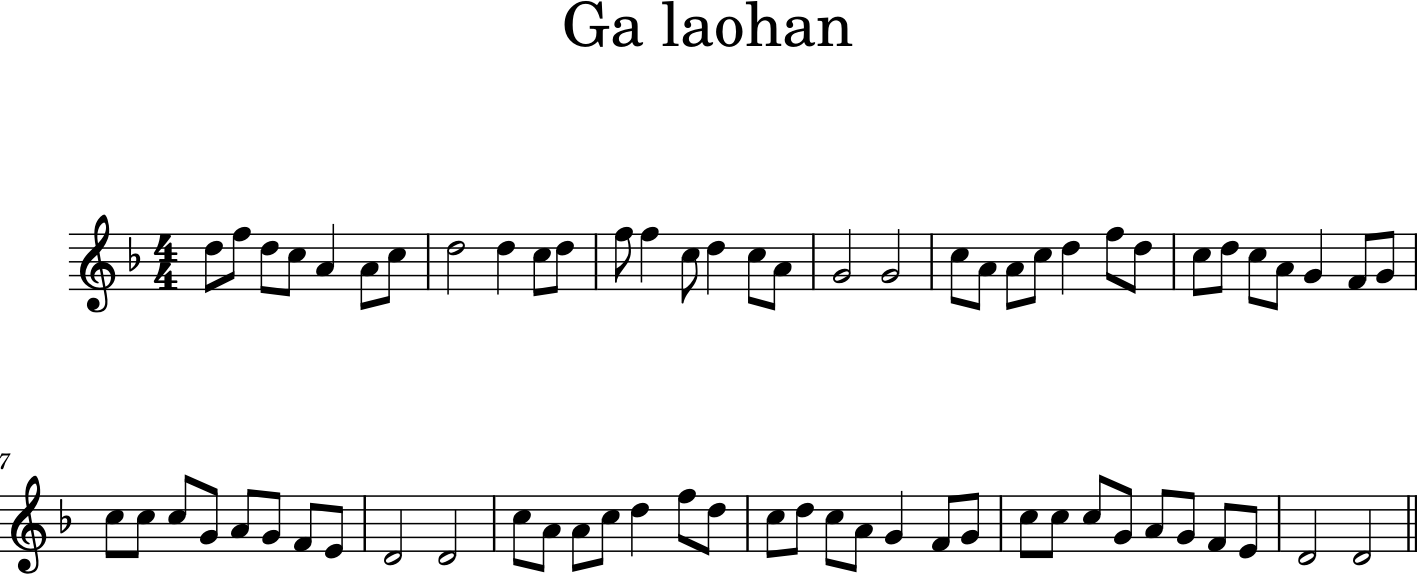

In [124]:
sample_score = converter.parse("./data/han/han0111.krn")
sample_score.show()

First, we are interested in the origin of the song that is provided as a Global comment in the *\*kern files. While the regional category (*Han*) is obtained through the name of the folder, the more precise origin of the song is contained in a `GlobalReference` with the code `ARE`. To access it, we need to iterate over all the elements of the score and get the value of the element whose code is `ARE`.

In [125]:
for element in sample_score:
    if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
        print("The origin of the score is in {}".format(element.value))

The origin of the score is in Asia, China,ÿQinghai, Osten


The origin information, however, is not formatted well and sometimes German and Chinese names are combined as shown above. In the later sections, we describe how we encode the songs using this origin information.

Second, as our analysis will rely on scale degrees, we will need to access the pitches and their durations, as well as the tonic. The following snippet allows us to access all the notes of the first measure and the tonic of the piece.

In [126]:
for part in sample_score.parts:
    for element in part.measure(0):
        if type(element) is key.Key:
            print(f"The tonic is : {element.tonic}")
        if type(element) is note.Note:
            print(element.pitch, element.duration.quarterLength)

The tonic is : F
D5 0.5
F5 0.5
D5 0.5
C5 0.5
A4 1.0
A4 0.5
C5 0.5


The code snippet above shows that the tonic of this piece is F. For this project, we define the tonic as a central pitch, i.e. the most recurring pitch that has a high duration (multiplied with beat strength) or the pitch that ends the piece. In the sample score, there are only two short F and it doesn't correspond to our definition. Thus we conclude that it is unlikely that F is the tonic of this sample score. However, we notice that the D should be the tonic following our definition as it is often used on high tonal hierarchy (i.e. it is the first note of the score and often comes as the first note of the measure) and as it is the last note of the piece.

Therefore we developed the following algorithm that returns the tonic following our definition. It computes a centrality for each pitch based on the pitch duration and the beat strength. Additionally, the last pitch of the piece gets added weight proportional to the song's length. The note with the highest score is then determined as the tonic. 

*Note*: As the for-loop that is used is time costly, we decided to also use it to return the pitch classes as well as the 5 most central pitches, using our definition of centrality mentioned above.

In [127]:
def get_tonic_and_pitch_classes(score):
    """
    This function accepts a score and returns its tonic, pitch classes, and 5 most central pitches,
    using the method described above.
    """
    try:
        note_scores = dict()
        length = 0
        for part in score.parts:
            for measure in part:
                if type(measure) is not stream.Measure:
                    continue
                for note_ in measure:
                    if type(note_) is not note.Note:
                        continue
                    length += 1
                    if note_.name in note_scores.keys():
                        note_scores[note_.name] += note_.duration.quarterLength * note_.beatStrength
                    else:
                        note_scores[note_.name] = note_.duration.quarterLength * note_.beatStrength
                    last_note = note_.name
        note_scores[last_note] += 0.1 * length
        tonic = max(note_scores, key=note_scores.get)
    except:
        tonic = None
    
    pitchclasses = list(note_scores.keys())
    top5 = sorted(note_scores, key=note_scores.get, reverse=True)[:5]
    return tonic, pitchclasses, top5

We can now infer the tonic of using this function

In [128]:
tonic, _, _ = get_tonic_and_pitch_classes(sample_score)
print(f"The tonic is : {tonic}")

The tonic is : D


Our custom algorithm thus infers D as being the tonic, which corresponds to our manual analysis of this piece.

With this information, we can now infer what pentatonic scale is used in this piece. For this purpose, we first need to transpose the piece to C relatively to its tonic (in this case a transposition of -2 since there are 2 semitones between C and D). We use *music21*'s `transpose` method to do it

In [129]:
transposed_score = sample_score.transpose(-2)

We can now use *music21*'s `plot` method to get a plot of the pitch classes used in this transposed piece.

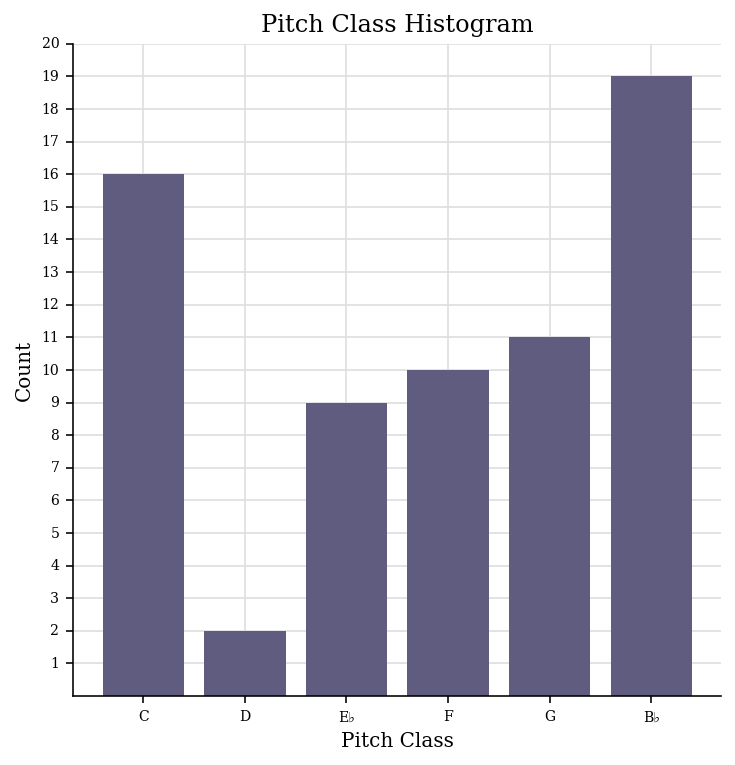

In [130]:
transposed_score.plot('histogram', 'pitchclass')

Next, using the top 5 transposed note, we can try to find which mode in pentatonic scale is used by each song. In Chinese music, we distinguish the 5 following modes with their five notes when transposed to C[[4]](https://digitalcommons.lsu.edu/cgi/viewcontent.cgi?article=2761&context=gradschool_dissertations):
* 宮 (gong, C) mode \[C D E G A\]
* 商 (shang, D) mode \[C D F G B<sub>b</sub>\]
* 角 (jue, E) mode \[C E<sub>b</sub> F A<sub>b</sub> B<sub>b</sub>\]
* 徵 (zhi, G) mode \[C D F G A\]
* 羽 (yu, A) mode \[C E<sub>b</sub> F G B<sub>b</sub>\]

Using this information, we then develop a function below that decides whether the 5 most central pitches of a piece indeed belong to one of these modes.

In [131]:
def get_mode(top5_pitches):
    if set(top5_pitches).issubset(['C', 'D', 'E', 'G', 'A']):
        return "gong"
    if set(top5_pitches).issubset(['C', 'D', 'F', 'G', 'B-']):
        return "shang"
    if set(top5_pitches).issubset(['C', 'E-', 'F', 'A-', 'B-']):
        return "jue"
    if set(top5_pitches).issubset(['C', 'D', 'F', 'G', 'A']):
        return "zhi"
    if set(top5_pitches).issubset(['C', 'E-', 'F', 'G', 'B-']):
        return "yu"
    return None

This simple function can now be used with the top 5 most central pitches of the sample score transposed to its tonic:

In [132]:
_, _, top_5_central = get_tonic_and_pitch_classes(transposed_score)
get_mode(top_5_central)

'yu'

Therefore, this piece is in yu mode, corresponding to the *minor* pentatonic scale.

### 1.7 Statistical Overview of the Dataset

#### 1.7.1 Creation of dataframe

In order to get an overview of the whole dataset, we will need to load it completely. As the files are divided into four different folders corresponding to the four regional categories, we first need to define the names of each of them.

In [133]:
regions = ["han", "natmin", "shanxi", "xinhua"]

We then define the function below that returns all *\*\*kern* scores in the given `path`, parsed with `music21`'s function.

In [134]:
def load_scores(path):
    """
    The function accepts a path and loads the .krn files in the path into a list.
    The pieces that are successfully parsed by the music21 parsers are stored in the scores list.
    In case the parser fails to load any file, they are stored in failed_scores.
    The count of total scores and failed scores are stores in total and failed counters.
    """
    
    pieces = {"scores": [], "failed_scores": [], "total": 0, "failed": 0}
    for file in tqdm(glob.glob(path+"/*.krn")):
        pieces["total"] += 1
        try:
            pieces["scores"].append(converter.parse(file))
        except:
            pieces["failed"] += 1 
            pieces["failed_scores"].append(converter.parse(file))
            
    return pieces

We can now iterate over the four regions, also corresponding to the four folders, and use the `load_score` function defined above to retrieve all scores of our dataset.

In [135]:
music_data = {} # A dictionary to store the music scores belonging to the 4 regions of the CFS as per the dataset.
# The key is the name of the region and the value is dictionay with keys corresponding to scores,
# failed_scores - Representing scores that have not loaded properly,
# total - representing the total number of scores of that region and failed - representing the total number of scores that have failed to be parsed.

for region in regions:
    music_data[region] = load_scores("./data/" + region)

100%|██████████| 10/10 [00:00<00:00, 128.20it/s]


##### Logic for the creation of one row in the data frame.

Currently, the music scores are store in a dictionary `music_data` with a key as the geographical region. For practical reasons, we will convert it into a `panda`'s `DataFrame`. The conversion will use the following logic:

- Create an empty list to hold the individual scores.
- For each geographic region
    - Get the music pieces of the region.
    - For each piece
        1. we get the title of the piece
        2. we get the number notes in the piece
        3. we get the location to which the piece belongs (finer than region).
        4. we use the `get_tonic` function to obtain the tonic, pitch classes, and the 5 most central pitch classes present in the piece.
        5. We transpose the piece to C and obtain the new pitch classes using the `get_tonic` function.
            - We calculate the number of semitones between the tonic of the piece and 'C' and transpose the piece by that value
        6. We then get the pitches present in the transposed piece
        7. We add the scale of the piece using the top 5 most central pitches of the transposed piece.
        8. All this information is appended to the list
- Create a DataFrame by given appropriate column names to the list
        
The implementation of this algorithm is given below.

In [136]:
# create a empty list to store information about each piece.
CFS_list = []

for region in tqdm(music_data):
    for score in music_data[region]["scores"]:
        
        title = score.metadata.title
        
        for element in score:
            if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
                location = element.value
                
        tonic, pitchclasses, _ = get_tonic_and_pitch_classes(score)
        num_pitchclass = len(pitchclasses)
        pitches = [str(pitch) for pitch in score.pitches]
        num_notes = len(pitches)
        
        # transposing
        i = interval.Interval(pitch.Pitch(tonic), pitch.Pitch("C")).semitones
        scoreNew = score.transpose(i)
        
        tonic_transposed, pitchclasses_transposed, top5 = get_tonic_and_pitch_classes(scoreNew)
        mode = get_mode(top5)
        pitches_transposed = [str(pitch) for pitch in scoreNew.pitches]
        
        CFS_list.append([region, title, location, tonic, pitches, num_notes, pitchclasses, num_pitchclass, tonic_transposed, pitches_transposed, pitchclasses_transposed, top5, mode])
CFS_full = pd.DataFrame(CFS_list, columns=["region", "title", "location", "tonic", "pitches", "num_notes", "pitchclasses", "num_pitchclasses","tonic_transposed", "pitches_transposed", "pitchclasses_transposed", "top5_after_transpose", "mode"])
CFS_full

100%|██████████| 4/4 [01:56<00:00, 29.01s/it]


,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose,mode
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]",shang
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]",None
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]",zhi
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]",shang
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]",yu
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236,xinhua,Moli hua,"Asia, China, Jiangsu",A,"[F#4, E4, F#4, A4, B4, A4, D5, B4, A4, F#4, A4...",174,"[F#, E, A, B, D]",5,C,"[A3, G3, A3, C4, D4, C4, F4, D4, C4, A3, C4, D...","[A, G, C, D, F]","[C, F, G, D, A]",zhi
2237,xinhua,Yitang qingshui yitang lian,"Hunan, Hengshan",C#,"[C#5, E5, C#5, C#6, E6, B5, B5, G#5, C#6, B5, ...",90,"[C#, E, B, G#, F#]",5,C,"[C5, E-5, C5, C6, E-6, B-5, B-5, G5, C6, B-5, ...","[C, E-, B-, G, F]","[C, G, F, B-, E-]",yu
2238,xinhua,Ta4i ya2ng chu1 la2i xi3 ya2ng ya2ng Auf geht ...,"Asia, Ostasien, China, Sichuan",E,"[E4, F#4, E4, D4, E4, F#4, D4, E4, F#4, E4, E4...",30,"[E, F#, D, B, A]",5,C,"[C4, D4, C4, B-3, C4, D4, B-3, C4, D4, C4, C4,...","[C, D, B-, G, F]","[C, B-, G, F, D]",shang
2239,xinhua,Moli hua,"Asia, China, Jiangsu",A,"[F#4, E4, F#4, A4, B4, A4, D5, B4, A4, F#4, A4...",174,"[F#, E, A, B, D]",5,C,"[A3, G3, A3, C4, D4, C4, F4, D4, C4, A3, C4, D...","[A, G, C, D, F]","[C, F, G, D, A]",zhi


#### 1.7.2 Dataset statistics

The first plot below shows the distribution of tonics, following our definition, that has been inferred with our algorithm.

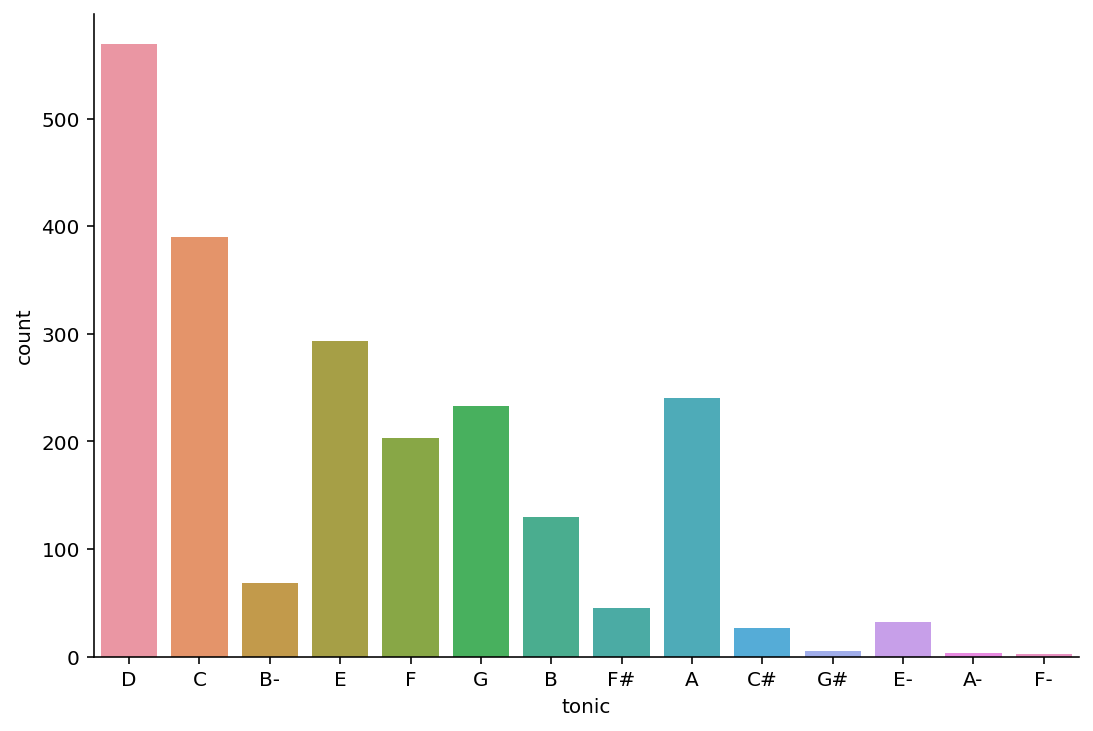

In [137]:
sns.catplot(x="tonic", kind="count", data=CFS_full, aspect=1.5)

The most frequent tonic across all the pieces is **D**, followed by **C**. Similarly, We can also plot the pentatonic scales used by these songs.

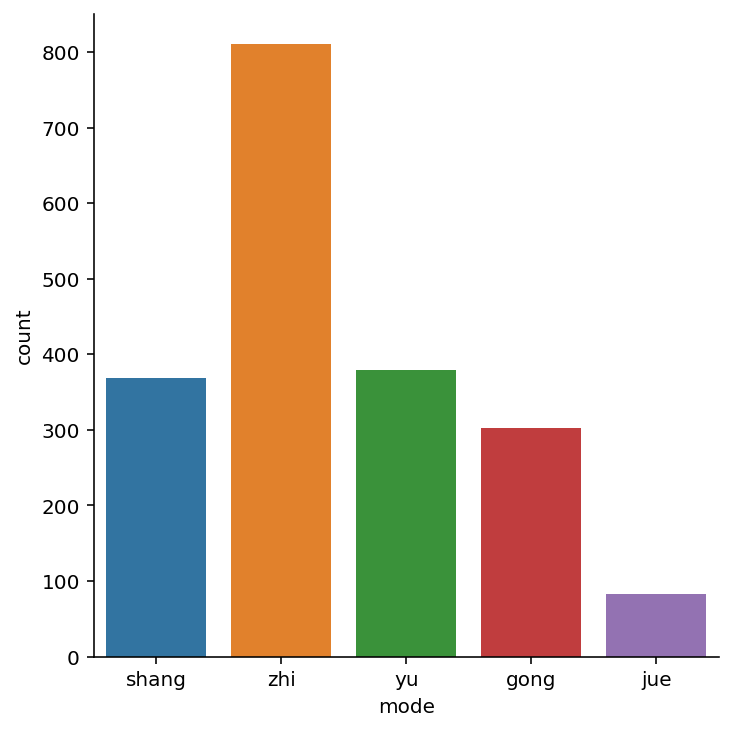

In [138]:
sns.catplot(data = CFS_full, x = "mode", kind="count")

From the plot above, we see that the **zhi** mode is more prominent followed by **yu** and **shang**. It is important to note that we could not infer the mode for some songs. The following snippet gives the percentage of such songs.

In [139]:
not_found_percentage = 1-CFS_full["mode"].value_counts().sum()/len(CFS_full)
print(f"The mode could not be infered for {not_found_percentage*100:.5f}% of the dataset")

The mode could not be infered for 13.29763% of the dataset


This percentage remains relatively low considering it relies on our custom definition of the tonic and the basic algorithm that detects the top 5 most central pitches.

Next, the plot below depicts the number of CFS in each annotated region

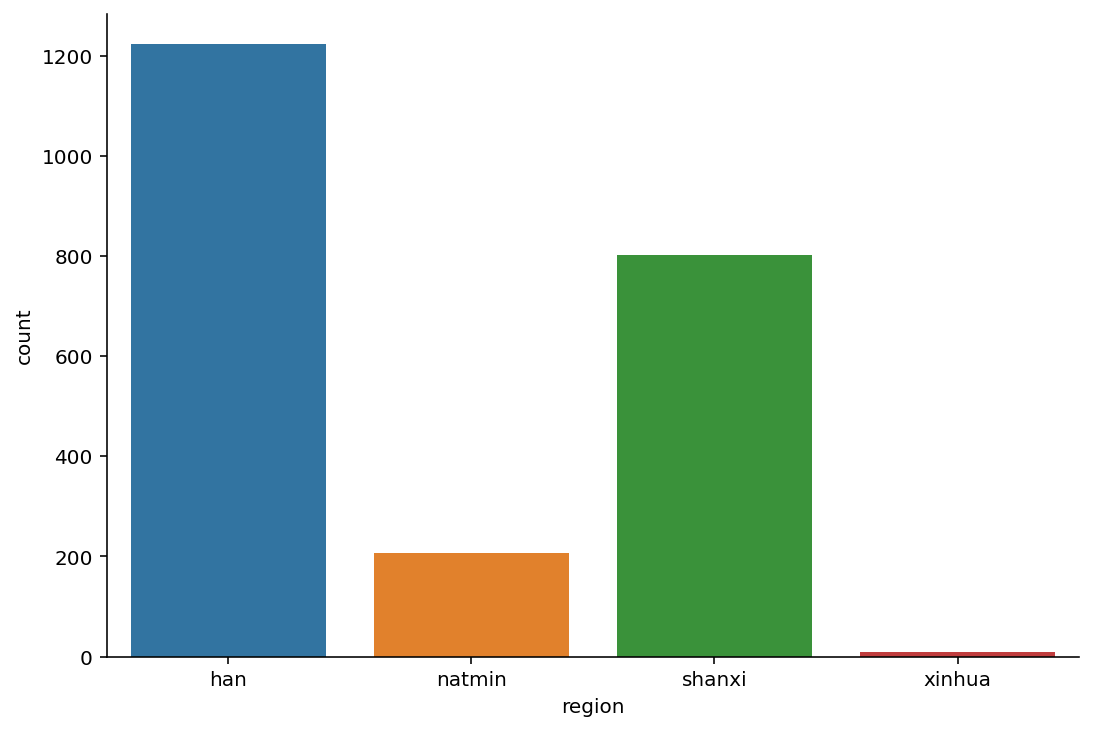

In [140]:
sns.catplot(x="region", kind="count", data=CFS_full, aspect=1.5)

We observe that the highest number of pieces are from Han (\~1200), followed by Shanxi (\~800). The least number of pieces are from Natmin (\~200) and Xinhua (=10). Clearly, the number of songs from the Xinhua region is underrepresented in the dataset when compared with other regions.

The following plots depict the number of notes in each piece across the four regions.

Text(0.5, 1.0, 'Distribution of length of Chinese Folk Songs from each region')

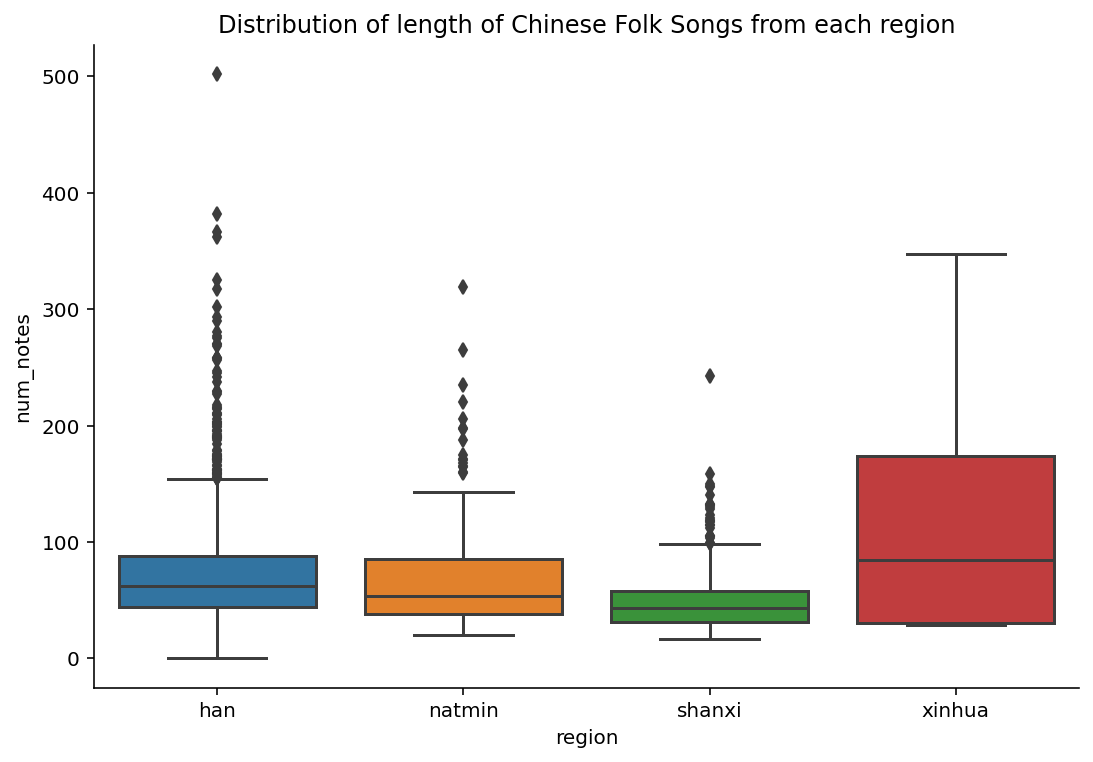

In [141]:
sns.catplot(x="region", y="num_notes", data=CFS_full, kind="box", aspect=1.5)
plt.title("Distribution of length of Chinese Folk Songs from each region")

On average each piece has 70 to 75 notes in the Han, Shanxi, and Natmin regions, whereas the mean number of notes in Xinhua is around 120

Similarly to the number of notes, we look at the number of pitch classes present in pieces across regions.

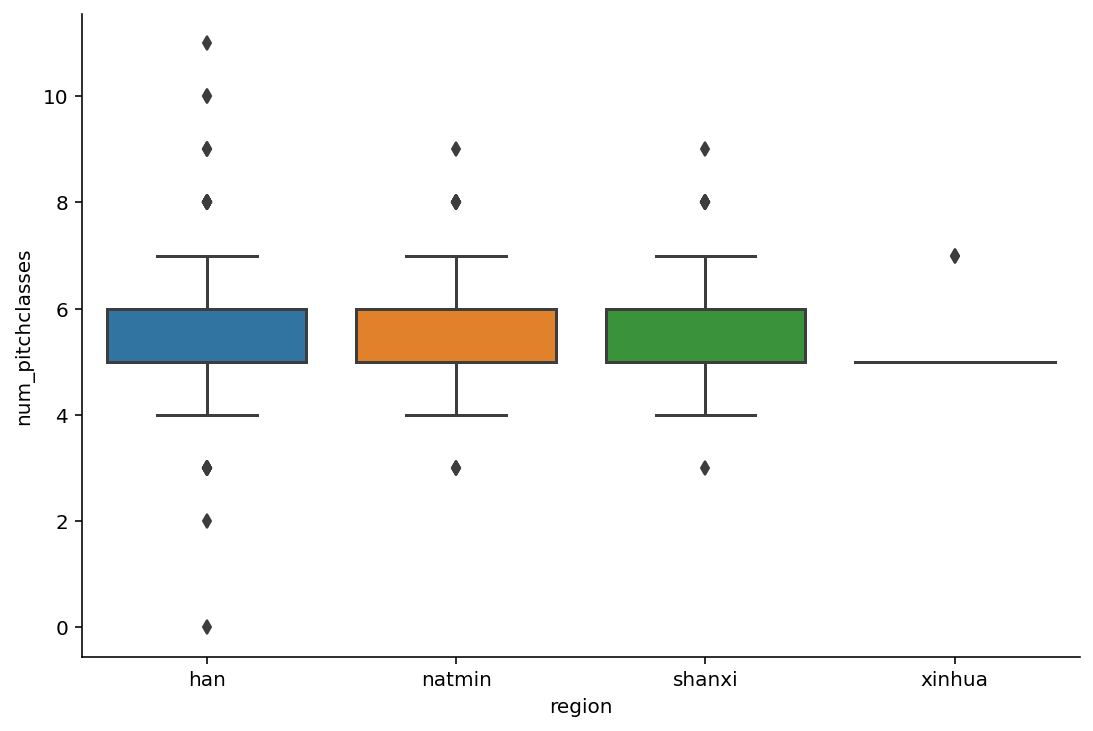

In [142]:
sns.catplot(x="region", y="num_pitchclasses", data=CFS_full, kind="box", aspect=1.5)

The plot above clearly indicates the mean as being 5, thus reinforcing our assumptions that the pieces are in the pentatonic scale.

Next, we plot the pentatonic scales used by pieces from each region.

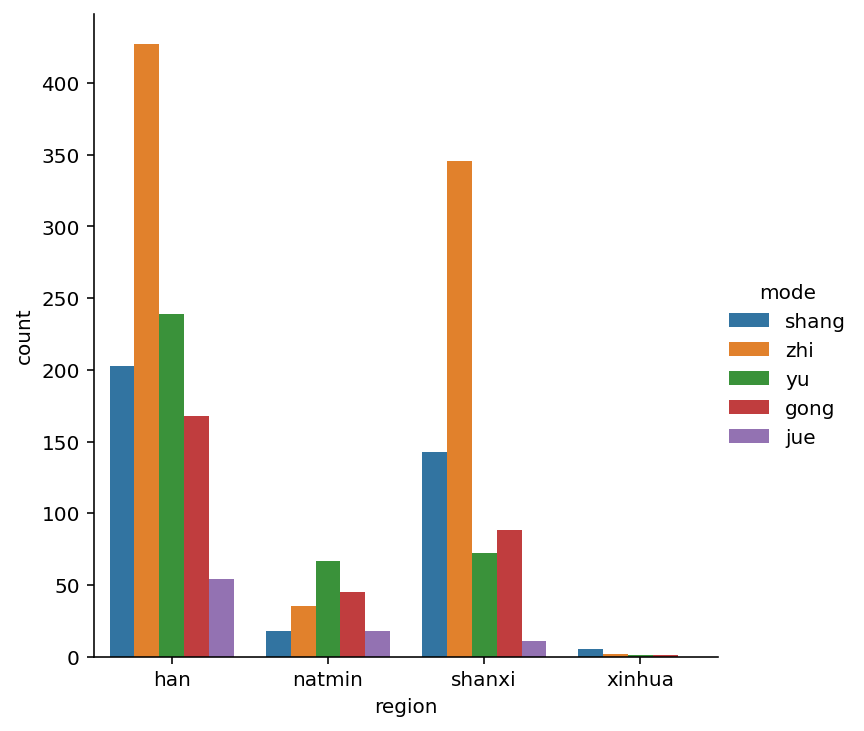

In [143]:
sns.catplot(data = CFS_full, x = "region", kind="count",hue="mode")

We observe that the `zhi` mode is most commonly used in **Han** and **Shanxi** regions where the most number of CFS are from in the dataset. The `yu` mode is more prevalent in the **Natmin** region and the `shang` mode in the **Xinhua** region.

### 1.8 Conclusion

Overall, we have decided on a dataset of CFS satisfying the requirements we laid out in milestone 1. The dataset contains 2250 pieces of music in a pentatonic scale belonging to 4 regions. We defined the tonic of a piece as the central pitch of the piece, i.e. the most recurring pitch that falls on a high duration (and beat strength) or the pitch that ends the piece. Using the tonic information, we then inferred the scale/mode to which each piece belongs.

## 2. Exploratory Analysis
In this section, we perform experiments on the entire dataset to understand and explore various information present in it.

### 2.1 Geographical information

As our research questions are based on understanding the differences across geographies, we are first to explore it using the origin information of each piece. As it is not clear what regions are understood by Han, Natmin, Shanxi, and Xinhua, we will geolocalise the location of each song using the origin attribute and put a colored marker on a world map for each of them. For that purpose, we use `geopy` and `folium`.

The function below takes as input a location name in the format `"Continent, Country, Province, City"` and tries to geolocate it as precisely as most, i.e. begin by the city, following by the province, etc...

In [22]:
cache = dict()
def name_to_geolocation(name):
    geolocator = Nominatim(user_agent = "DH-401 CFS locator")
    names = name.strip(" ").replace(", ", ",").replace(" ", ",").split(",")
    for i in range(len(names)):
        if names[len(names)-1-i] in cache.keys():
            return cache[names[len(names)-1-i]]
        location = geolocator.geocode(names[len(names)-1-i])
        if location is not None:
            break
    cache[names[len(names)-1-i]] = location
    return None

We can now use this function on the column `location` of the `DataFrame` to locate all songs. For each geolocation, we then add a marker on the map. Each region has a different color:
* Han: Blue
* Shanxi: Red
* Natmin : Black
* Xinhua: Green

Once all markers are added, we can display the map.

In [35]:
map_ = folium.Map()
locations = list()
for _, row in tqdm(CFS_full.iterrows()):
    geolocation = name_to_location(row["location"])
    if geolocation is None:
        continue
    if geolocation.latitude + geolocation.longitude in locations:
        continue
    if row["region"] == "han":
        color = "blue"
    elif row["region"] == "shanxi":
        color="red"
    elif row["region"] == "natmin":
        color="black"
    else:
        color = "green"
    folium.Marker([geolocation.latitude, geolocation.longitude], popup=row["location"], icon=folium.Icon(color=color)).add_to(map_)
    locations.append(geolocation.latitude + geolocation.longitude)
map_

2241it [07:41,  4.86it/s]


*Note* : if you cannot see the interactive map, you need to either trust this Notebook or execute the code.

The screenshot of the interactive map is shown below.

![map](img/regions_marker_map.png)

We directly notice two things on the above map:
* The geolocation is imperfect. Indeed, some locations are found in Europe. This is possibly due to the information present in origin attribute as it contains a German region name (e.g. "Sichuan, Ostteil").  The other reason is the limitation of geopy to precisely translate the text to geo coordinates. However, the purpose of this map is not to get precise locations but to get a general idea of what the different regions represent. The markers are clickable and it shows the origin attribute using which the marker is place.

* It clearly appears that the regions are mixed. 
  * The Han region spans the entirety of Western China and also includes many locations inside the Shanxi province.
  * The "Natmin" region is not clearly distinguishable.
  * The Shanxi region is the only one that seems correct and contained inside its province. Clicking the few outliers reveals they were misplaced by the geolocator and should be inside the Shanxi province.

This geographical exploration concludes that we cannot use these annotated four regions to answer our research questions. Indeed, we would not be able to make any claims about regional differences if the regions overlap and are ill-defined.

Therefore, we define our regional categories using the following map and call them geographical divisions:

![map](img/map.JPG)

We group the provinces and create 9 divisions and assign them to each song by looking at its province.

In [144]:
CFS_full['geo_division'] = ''
CFS_full.loc[CFS_full['location'].str.contains('Shanxi|Ningxia|Gansu|Qinghai'), ['geo_division']] = 'Northwest'
CFS_full.loc[CFS_full['location'].str.contains('Neimeng'), ['geo_division']] = 'Neimeng'
CFS_full.loc[CFS_full['location'].str.contains('Shandong|Hebei|Liaoning|Jilin|Heilongjiang'), ['geo_division']] = 'Northeast'
CFS_full.loc[CFS_full['location'].str.contains('Jiangsu|Anhui|Zhejiang'), ['geo_division']] = 'Jiangzhe'
CFS_full.loc[CFS_full['location'].str.contains('Hubei|Hunan|Henan|Jiangxi'), ['geo_division']] = 'Central'
CFS_full.loc[CFS_full['location'].str.contains('Fujian|Guangdong|Taiwan'), ['geo_division']] = 'Southeast'
CFS_full.loc[CFS_full['location'].str.contains('Sichuan|Chongqing|Yunnan|Guangxi|Hainan'), ['geo_division']] = 'Southwest'
CFS_full.loc[CFS_full['location'].str.contains('Xinjiang'), ['geo_division']] = 'Jiang' 
CFS_full.loc[CFS_full['location'].str.contains('Xizang'), ['geo_division']] = 'Zang'
CFS_full.loc[CFS_full['geo_division'] == '', ['geo_division']] = 'Null' 
CFS_full.head()

,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose,mode,geo_division
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]",shang,Northwest
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]",None,Northwest
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]",zhi,Northwest
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]",shang,Northwest
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]",yu,Northwest


Since the creation of this `DataFrame` is time costly, we store it as a csv file.

In [145]:
CFS_full.to_csv("./data/dataframes/cfs_full.csv", index=False)

##### Reading the data from CSV file

In order to read the DataFrame from the CSV file, we can use the `read_csv` function of `pandas`.

_Note_: We store the pitches, pitch classes (after and before transposition) as lists. Hence when reading the CSV, we use the `converters` parameter to convert these strings into Python's lists.

In [146]:
CFS_full = pd.read_csv("./data/dataframes/cfs_full.csv", converters={'pitches': eval,'pitchclasses': eval,'pitches_transposed': eval,'pitchclasses_transposed': eval,'top5_after_transpose': eval})
CFS_full.head()

,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose,mode,geo_division
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]",shang,Northwest
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]",NaN,Northwest
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]",zhi,Northwest
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]",shang,Northwest
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]",yu,Northwest


#### 2.1.1 Counts of songs in custom divisions

We can now display the count of songs in each of our 9 regions.

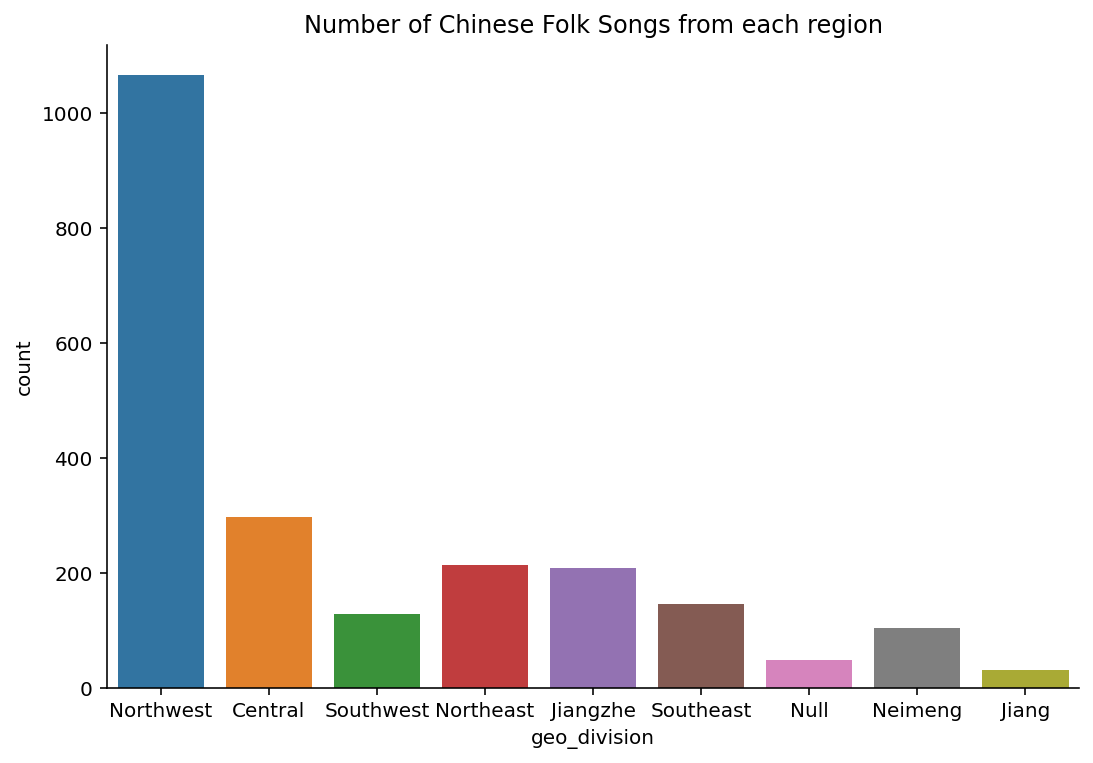

In [147]:
sns.catplot(x="geo_division", kind="count", data=CFS_full, aspect=1.5)
plt.title("Number of Chinese Folk Songs from each region")
plt.show()

Here we observe that the "Northwest" division possesses by far the most songs, but that other division still contain enough songs for analysis. Only the "Jiang" division has less than 100 songs and there are no songs from the "Zang" division. As it is evident from the plot, few pieces did not have provience information and hence labelled as Null. We will ignore those pieces and the Zang region (as there are no pieces from that region) from the further analysis.


## 2.2 Exploring regional differences

In this subsection we will explore the data in order to get insight on our research questions. We hypothesized that we could find notable differences in the modal organization of the songs of different regions(divisions). Therefore, in the following sections, we will group the songs by division, apply methods for each group, and compare the results.

### 2.2.1 Pitch statistics

In this subsection, we plot the combined pitch and scale degrees distributions of all the pieces combined for each division.

To do so, we first create empty dictionaries to store the pitches and scale degrees before and after transposition with division name as key and values as a list of pitches/scale degrees of all pieces belonging to that division.

In [162]:
# The manually annotated geographic divisions
geo_divisions = ["Northwest", "Central", "Southwest", "Northeast", "Jiangzhe", "Southeast", "Neimeng", "Jiang"]
pitch_classes_list = ['A', 'A#', 'A-', 'B', 'B#', 'B-', 'C', 'C#', 'C-', 'D', 'D#', 'D-', 'E', 'E#', 'E-', 'F', 'F#', 'G', 'G#', 'G-']

# Empty dictionaries to store pitches and 
region_pitch_stat = {}
region_scaledegree_stat = {}
region_pitch_transposed_stat = {}
region_scaledegree_transposed_stat = {}
region_tonic_stat = {}

scaledegree_defcount = {pc:0 for pc in pitch_classes_list}
pitchclass_transitions_defcount = {pc1:{pc2:0 for pc2 in pitch_classes_list} for pc1 in pitch_classes_list}

for gloc in geo_divisions: 
    region_df = CFS_full[CFS_full["geo_division"]==gloc]
    region_pitch_stat[gloc] = sum(region_df["pitches"].tolist(), [])
    region_scaledegree_stat[gloc] = sum(region_df["pitchclasses"].tolist(), [])
    region_pitch_transposed_stat[gloc] = sum(region_df["pitches_transposed"].tolist(), [])
    region_scaledegree_transposed_stat[gloc] = sum(region_df["pitchclasses_transposed"].tolist(), [])
    region_tonic_stat[gloc] = region_df["tonic"].tolist()

The pitch distribution can then be computed by counting the occurrence of each pitch. This distribution can then be shown with a bar plot.

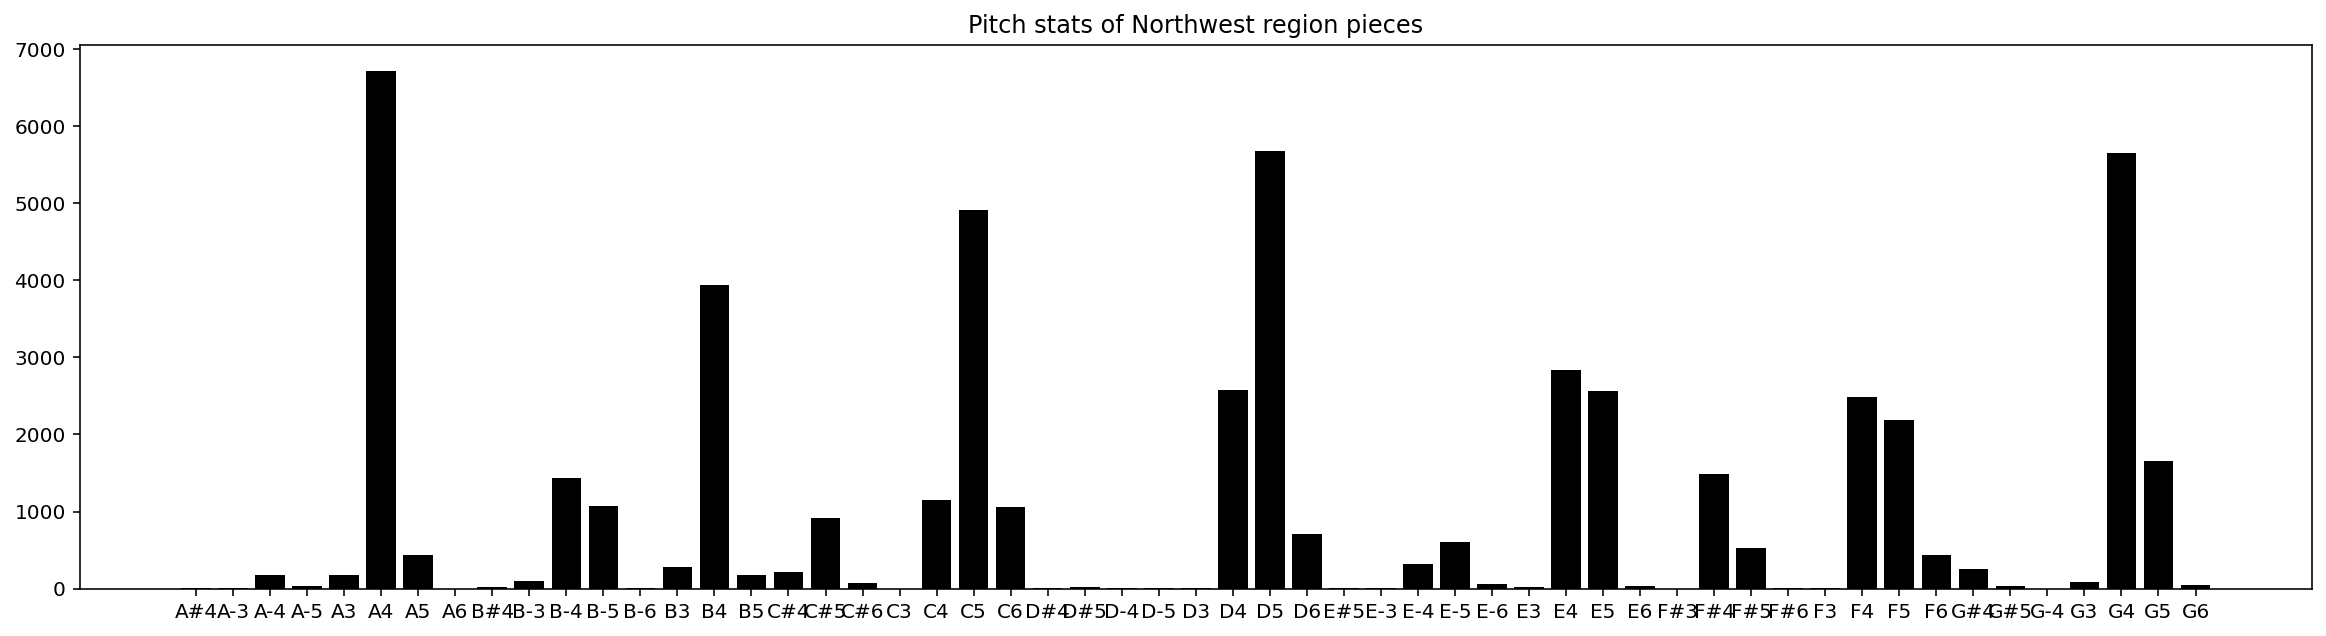

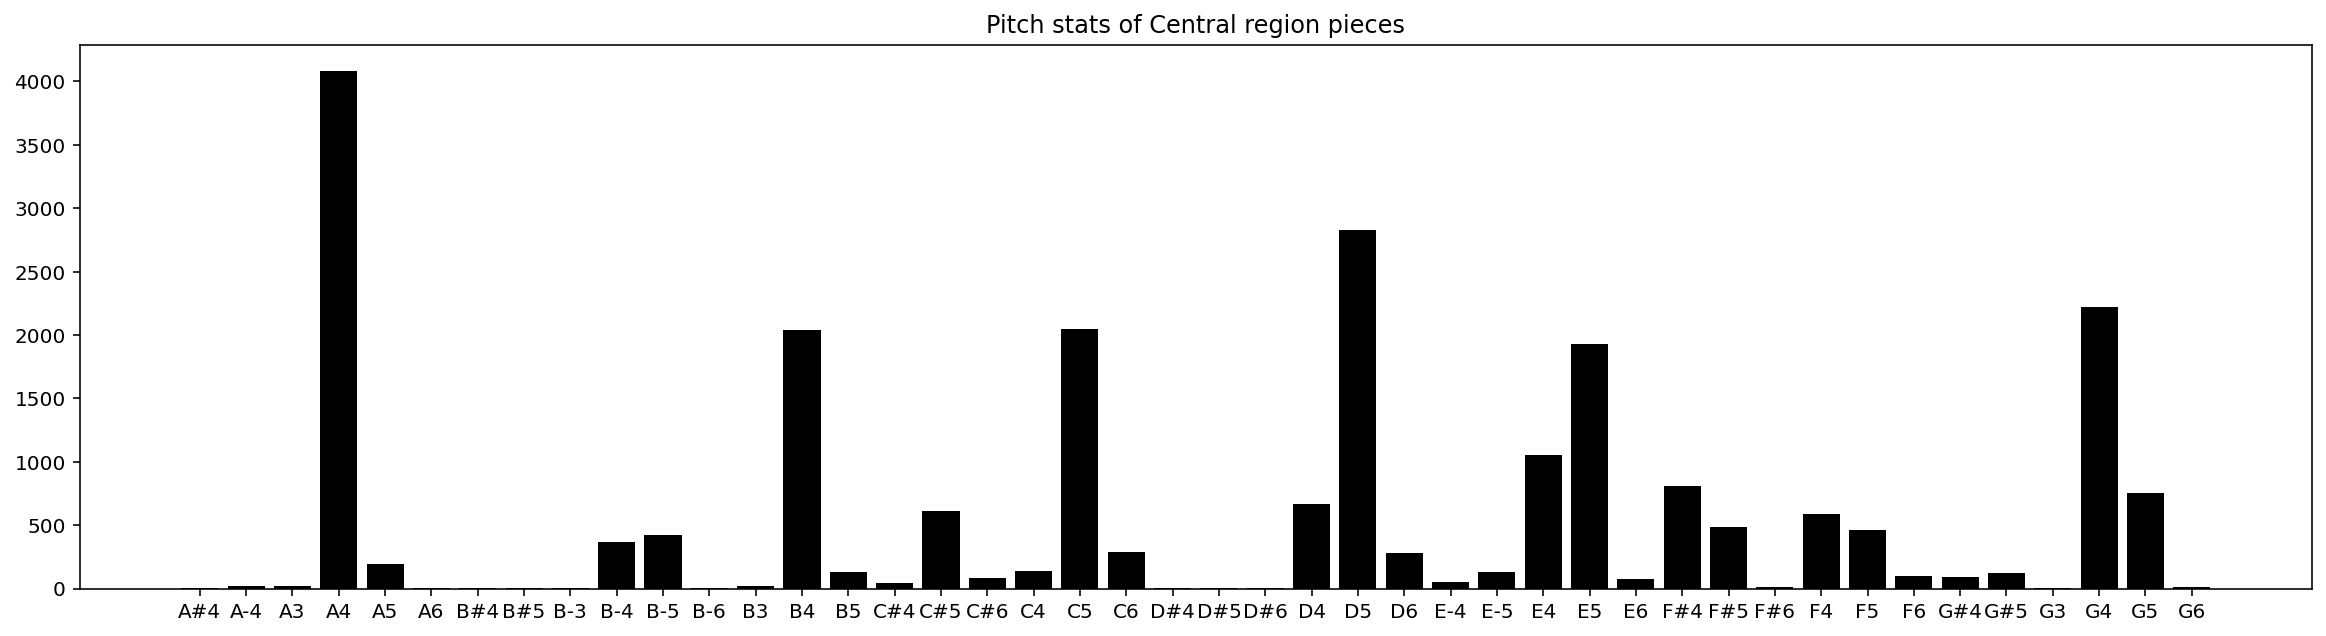

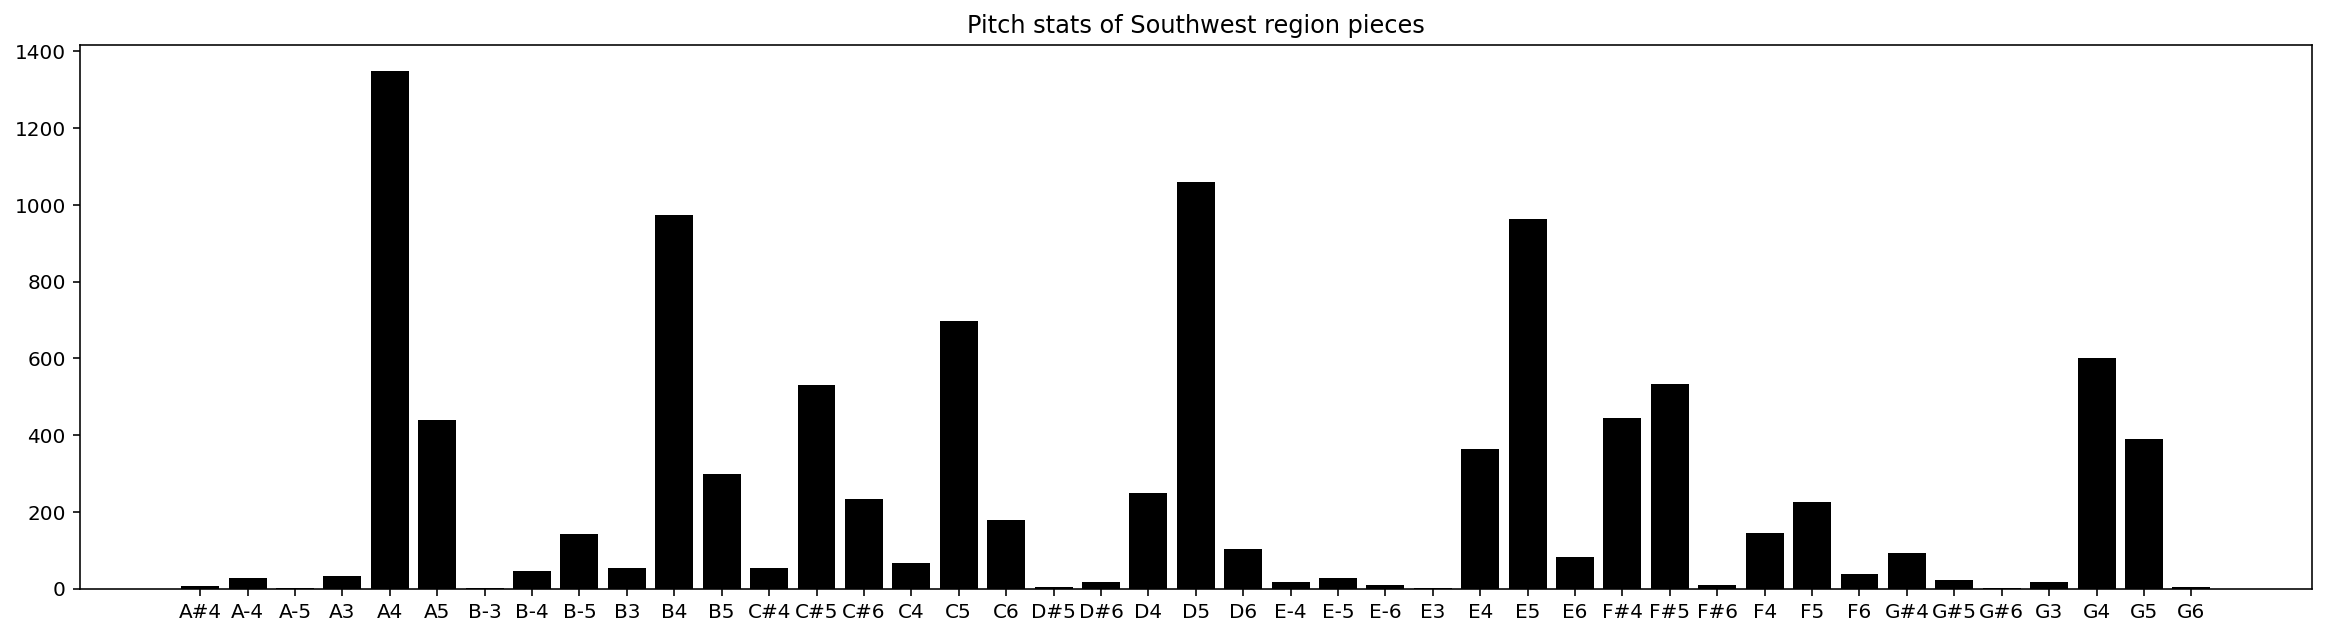

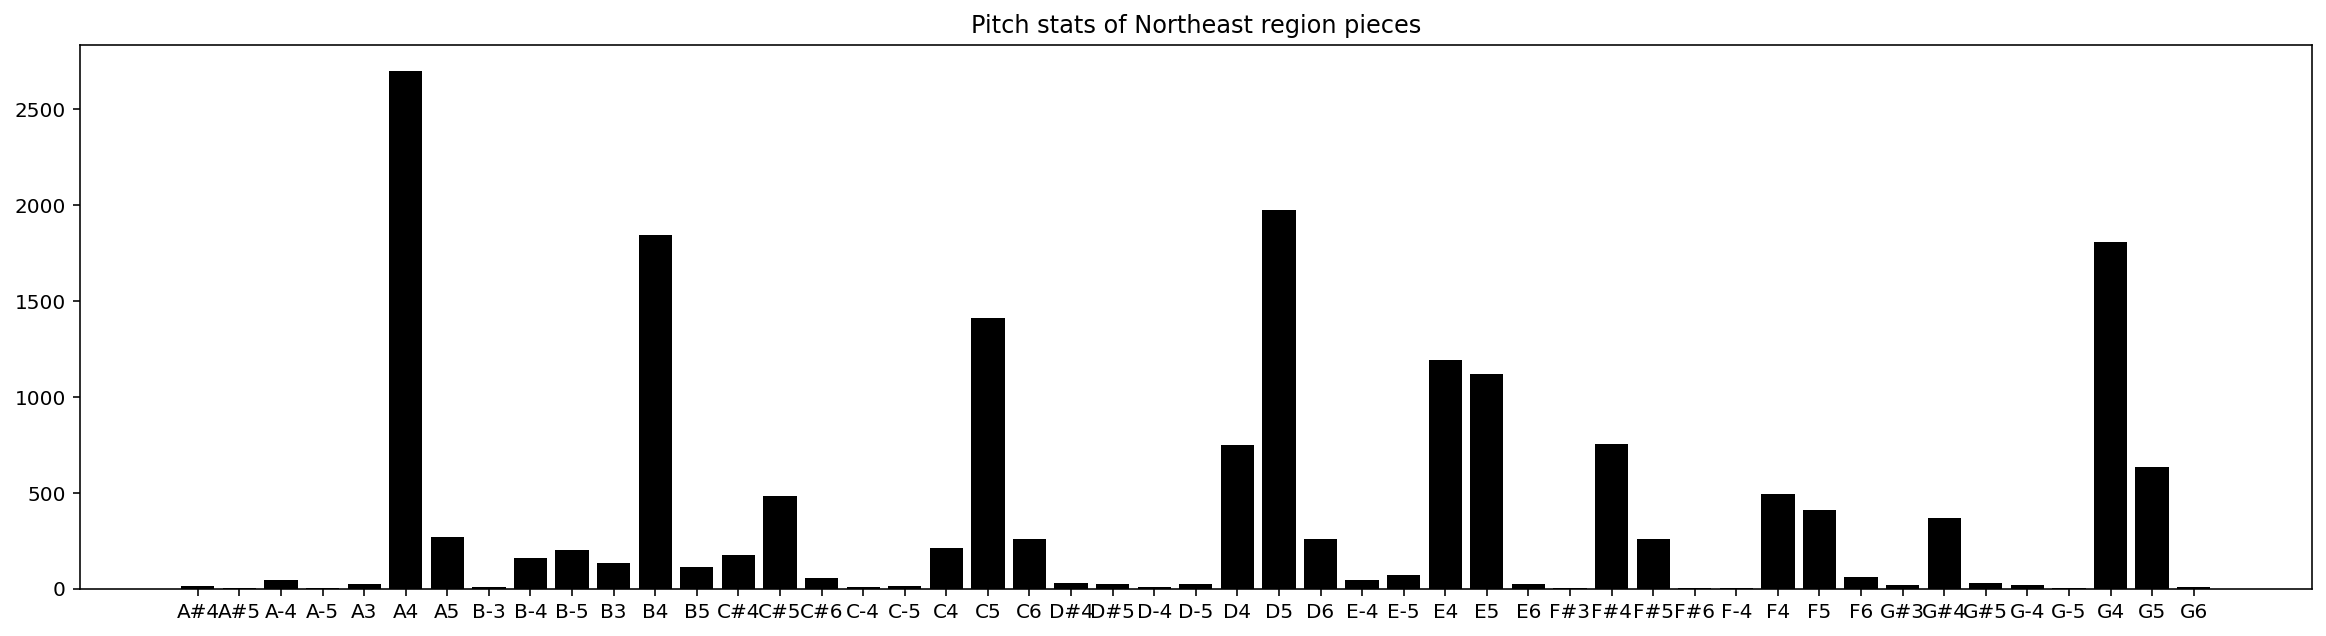

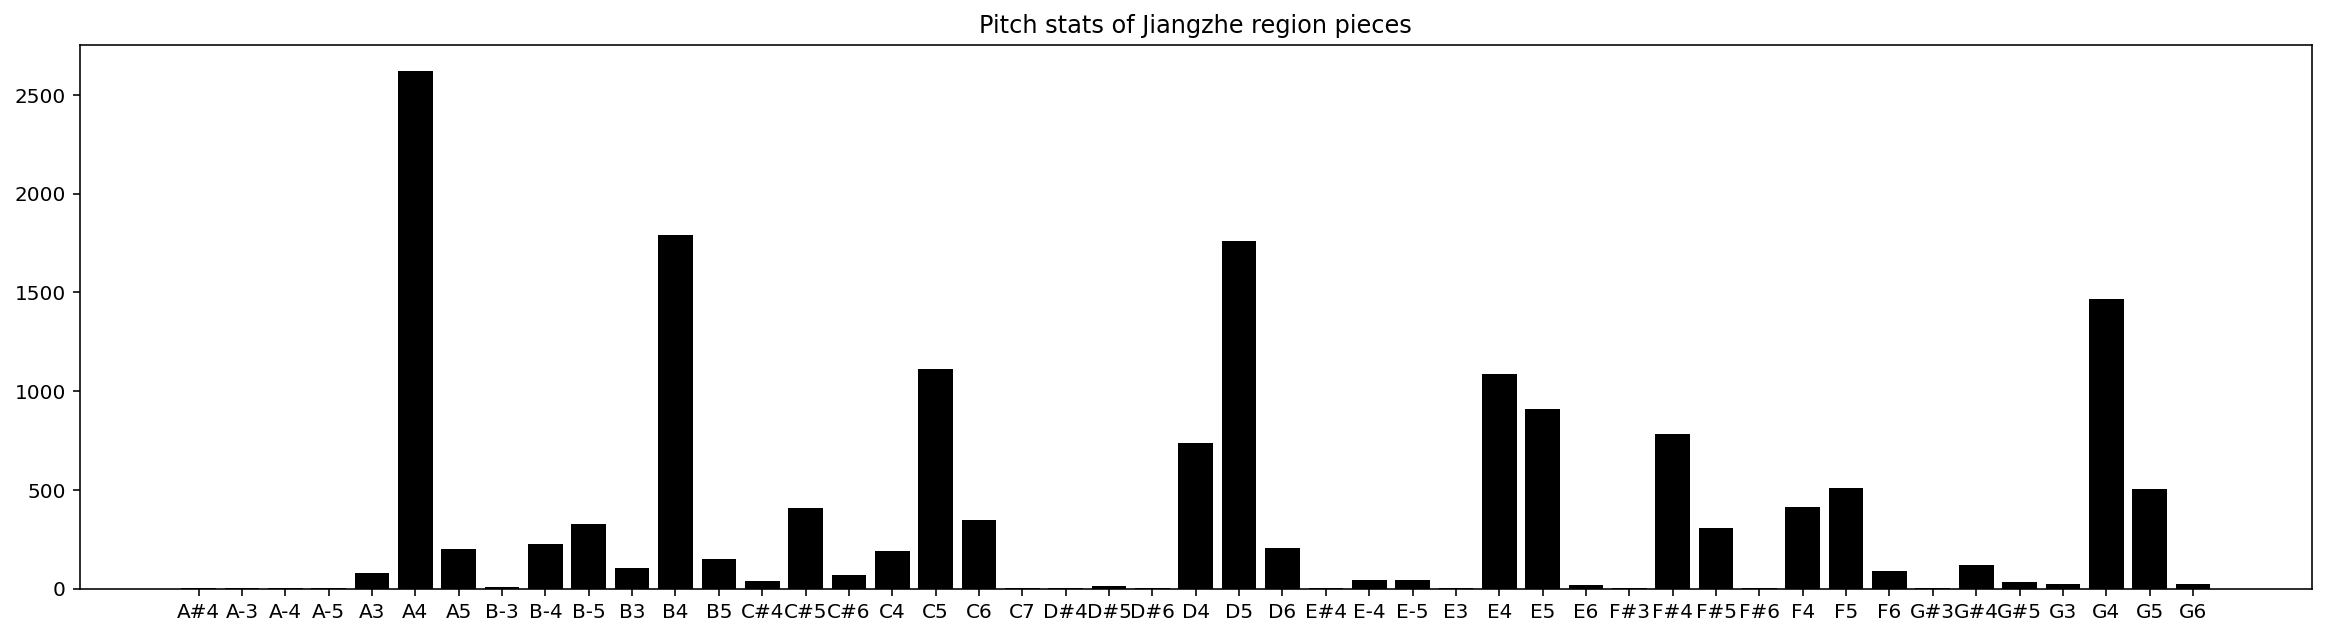

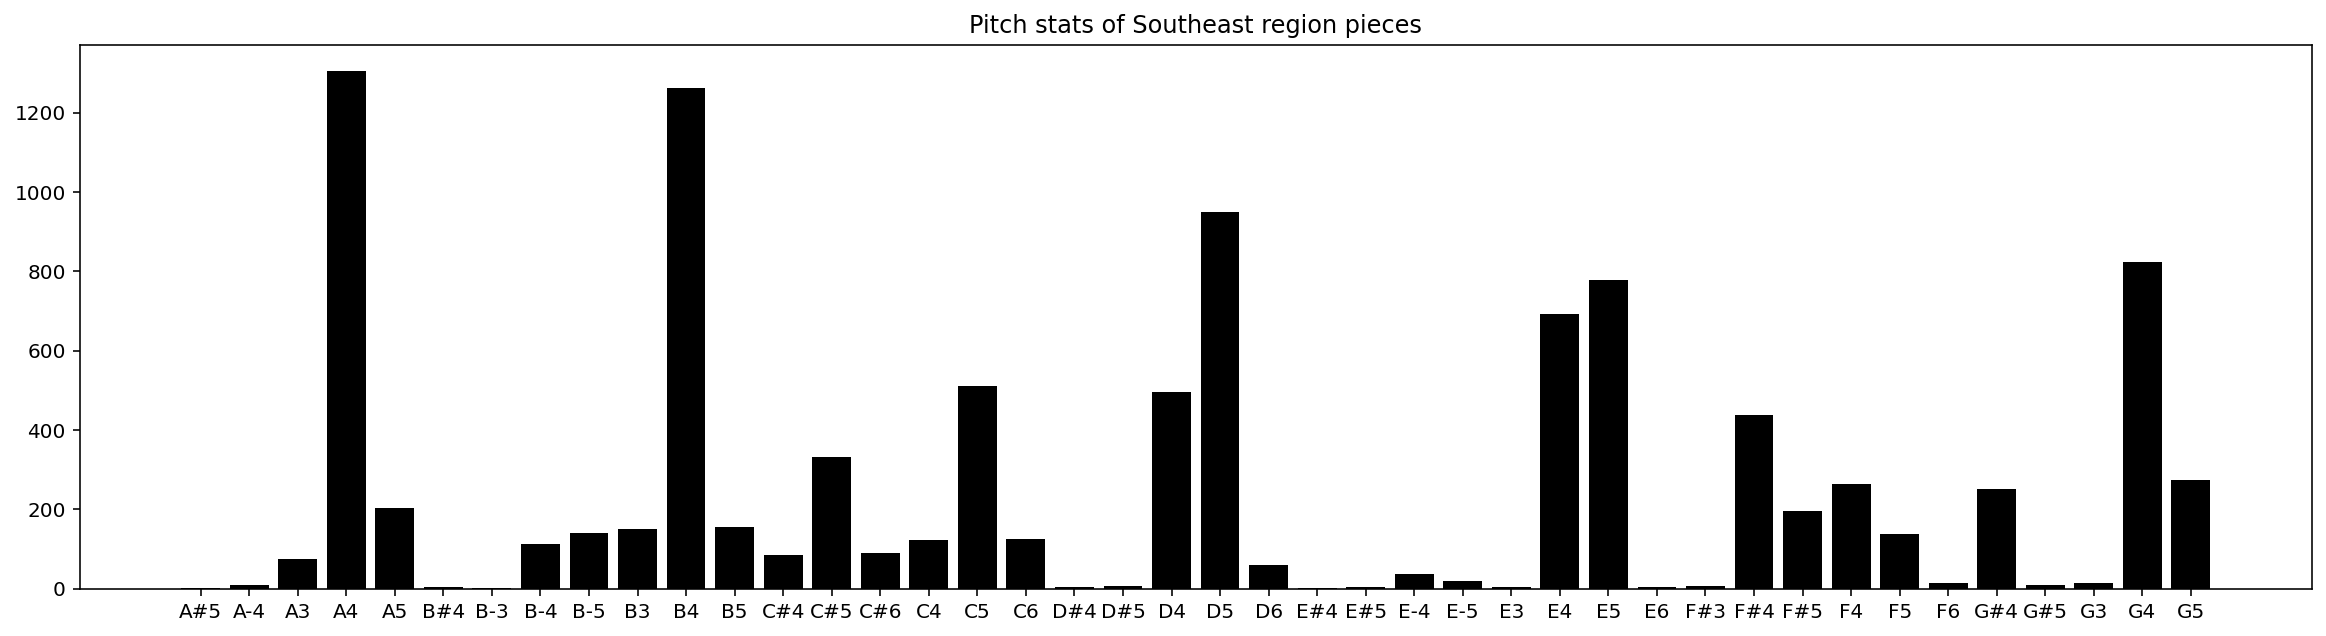

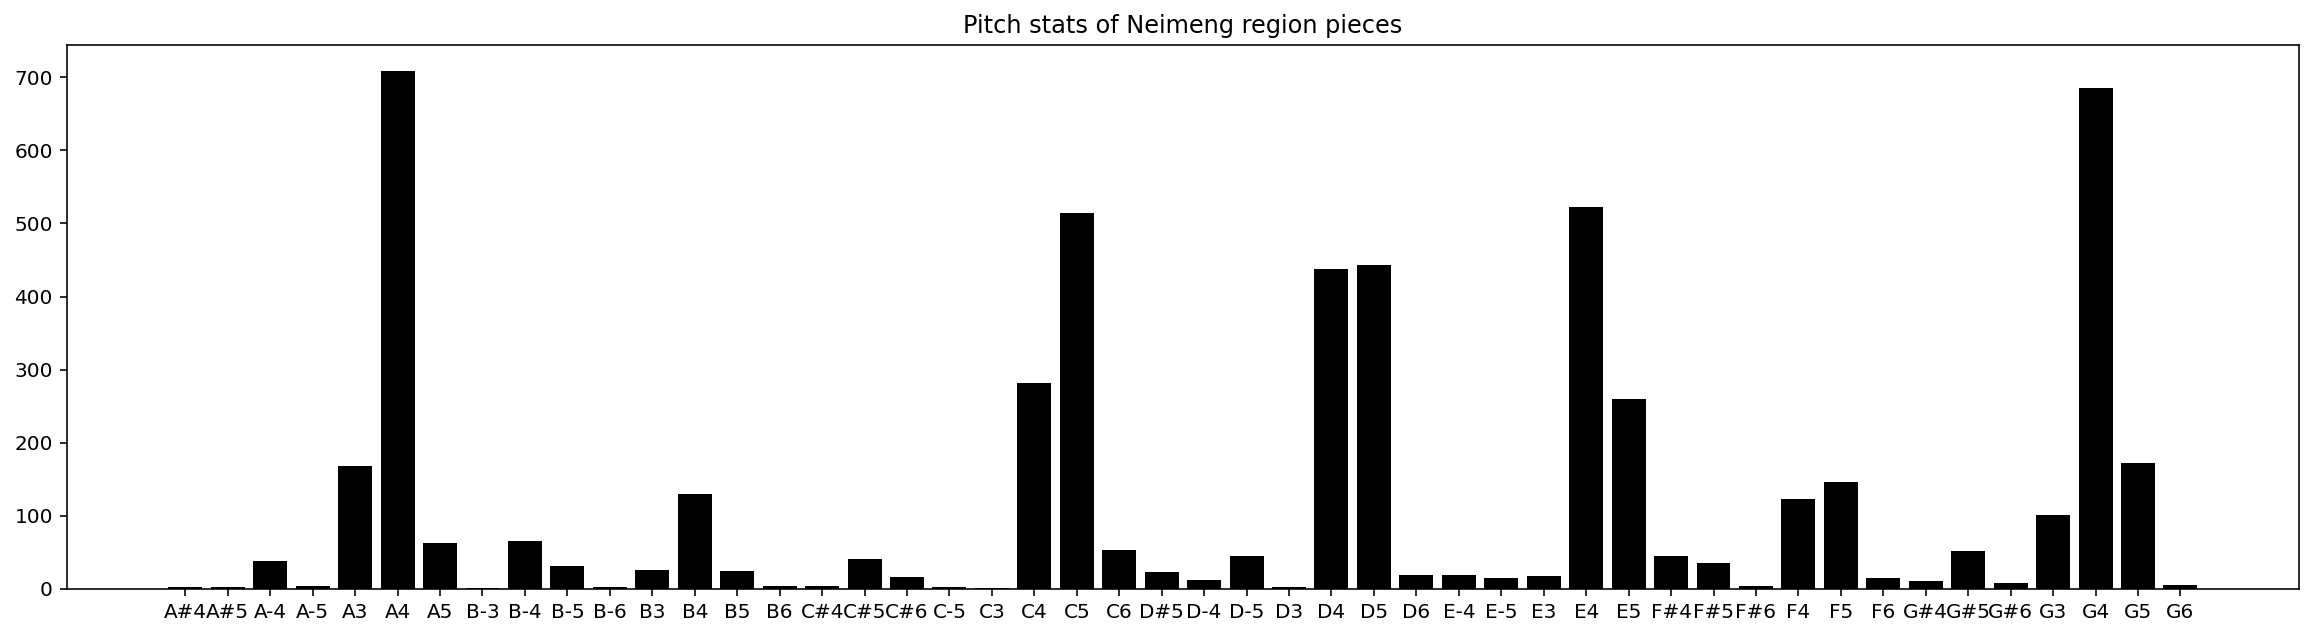

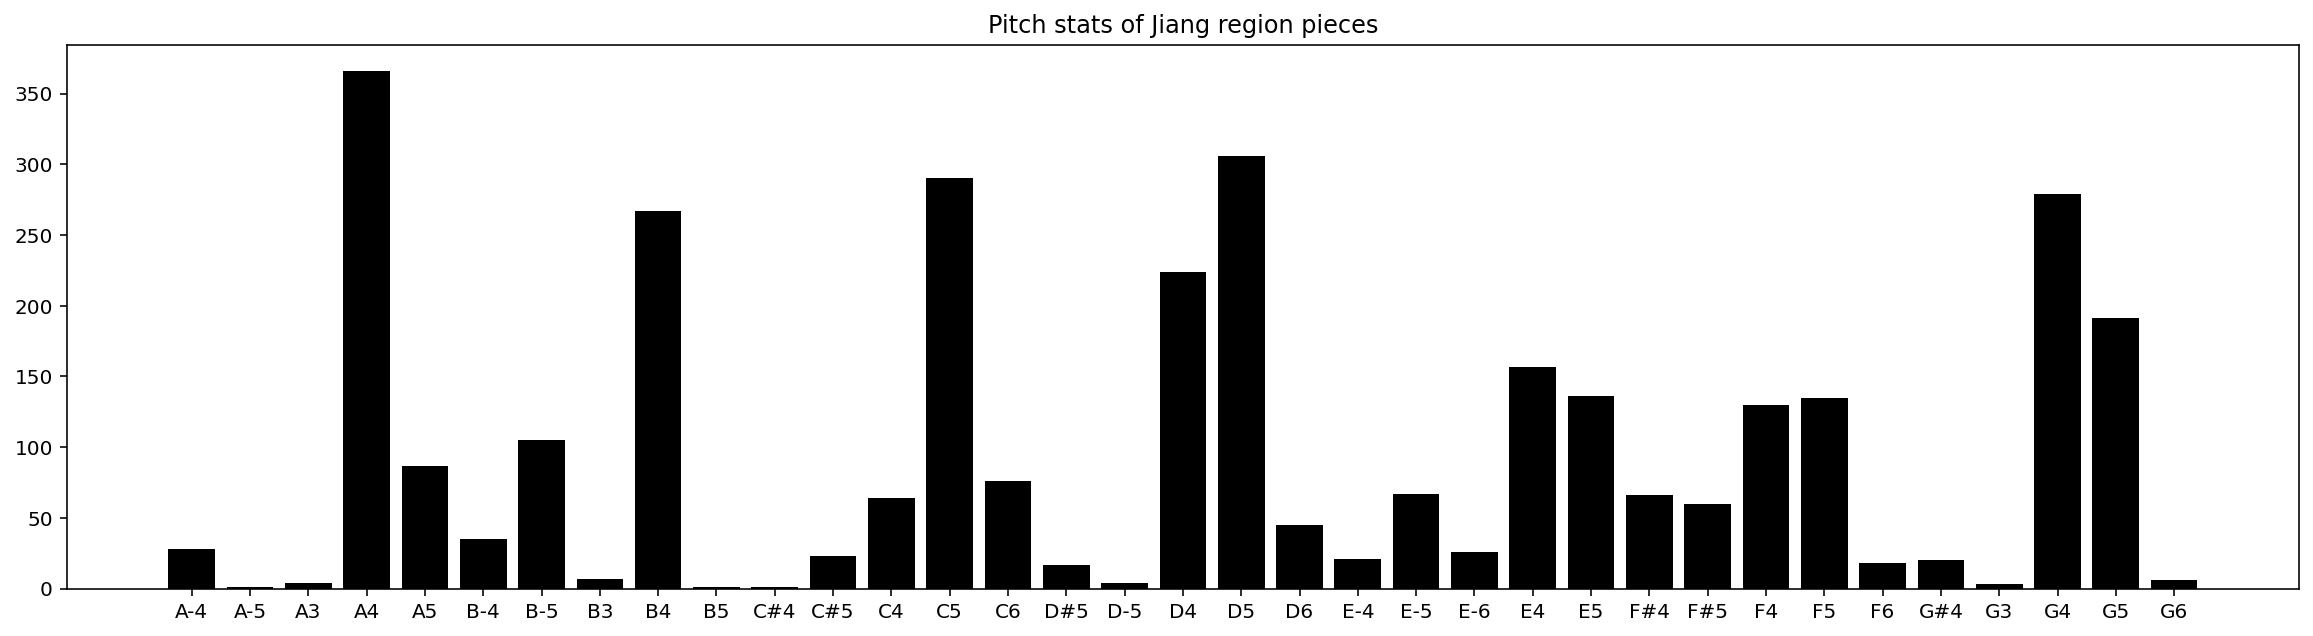

In [149]:
plt.rcParams["figure.figsize"] = (20,5)

region_pitch_counts = {}
for gloc in region_pitch_stat:
    
    counter = Counter(region_pitch_stat[gloc])
#     pitch_fractions = {i:counter[i] / len(region_pitch_stat[gloc]) for i in counter}
    pitch_fractions = {i:counter[i] for i in counter}
    region_pitch_counts[gloc] = sorted(pitch_fractions.items(), key=lambda pair: pair[0])
    
    x, y = zip(*region_pitch_counts[gloc])
    
    plt.bar(x, y, color='black')
    plt.title("Pitch stats of {} region pieces".format(gloc))
    plt.show()

By comparing each of these plots, we can get a first comparison of the pieces of each region. The first striking observation is that these distributions look similar across the regions. Indeed, we notice that A4, B4, C5, D5, and G4 are dominant in most regions. However, we can also observe differences. For instance, B4 is barely used in the Neimeng region compared to all the other ones.

These remarks give some first insight to our hypothesis: on average, there is no striking difference in the use of pitches across different regions of China. However, further analysis is required to determine the implications of the fluctuations.

### 2.2.2 Pitch class statistics
In the previous subsection, we compared the use of pitches across regions. As an additional comparison, we now plot the distribution of pitch class across regions.

For this visualization, we decided to sort the pitch classes by occurrences rather than alphabetically.

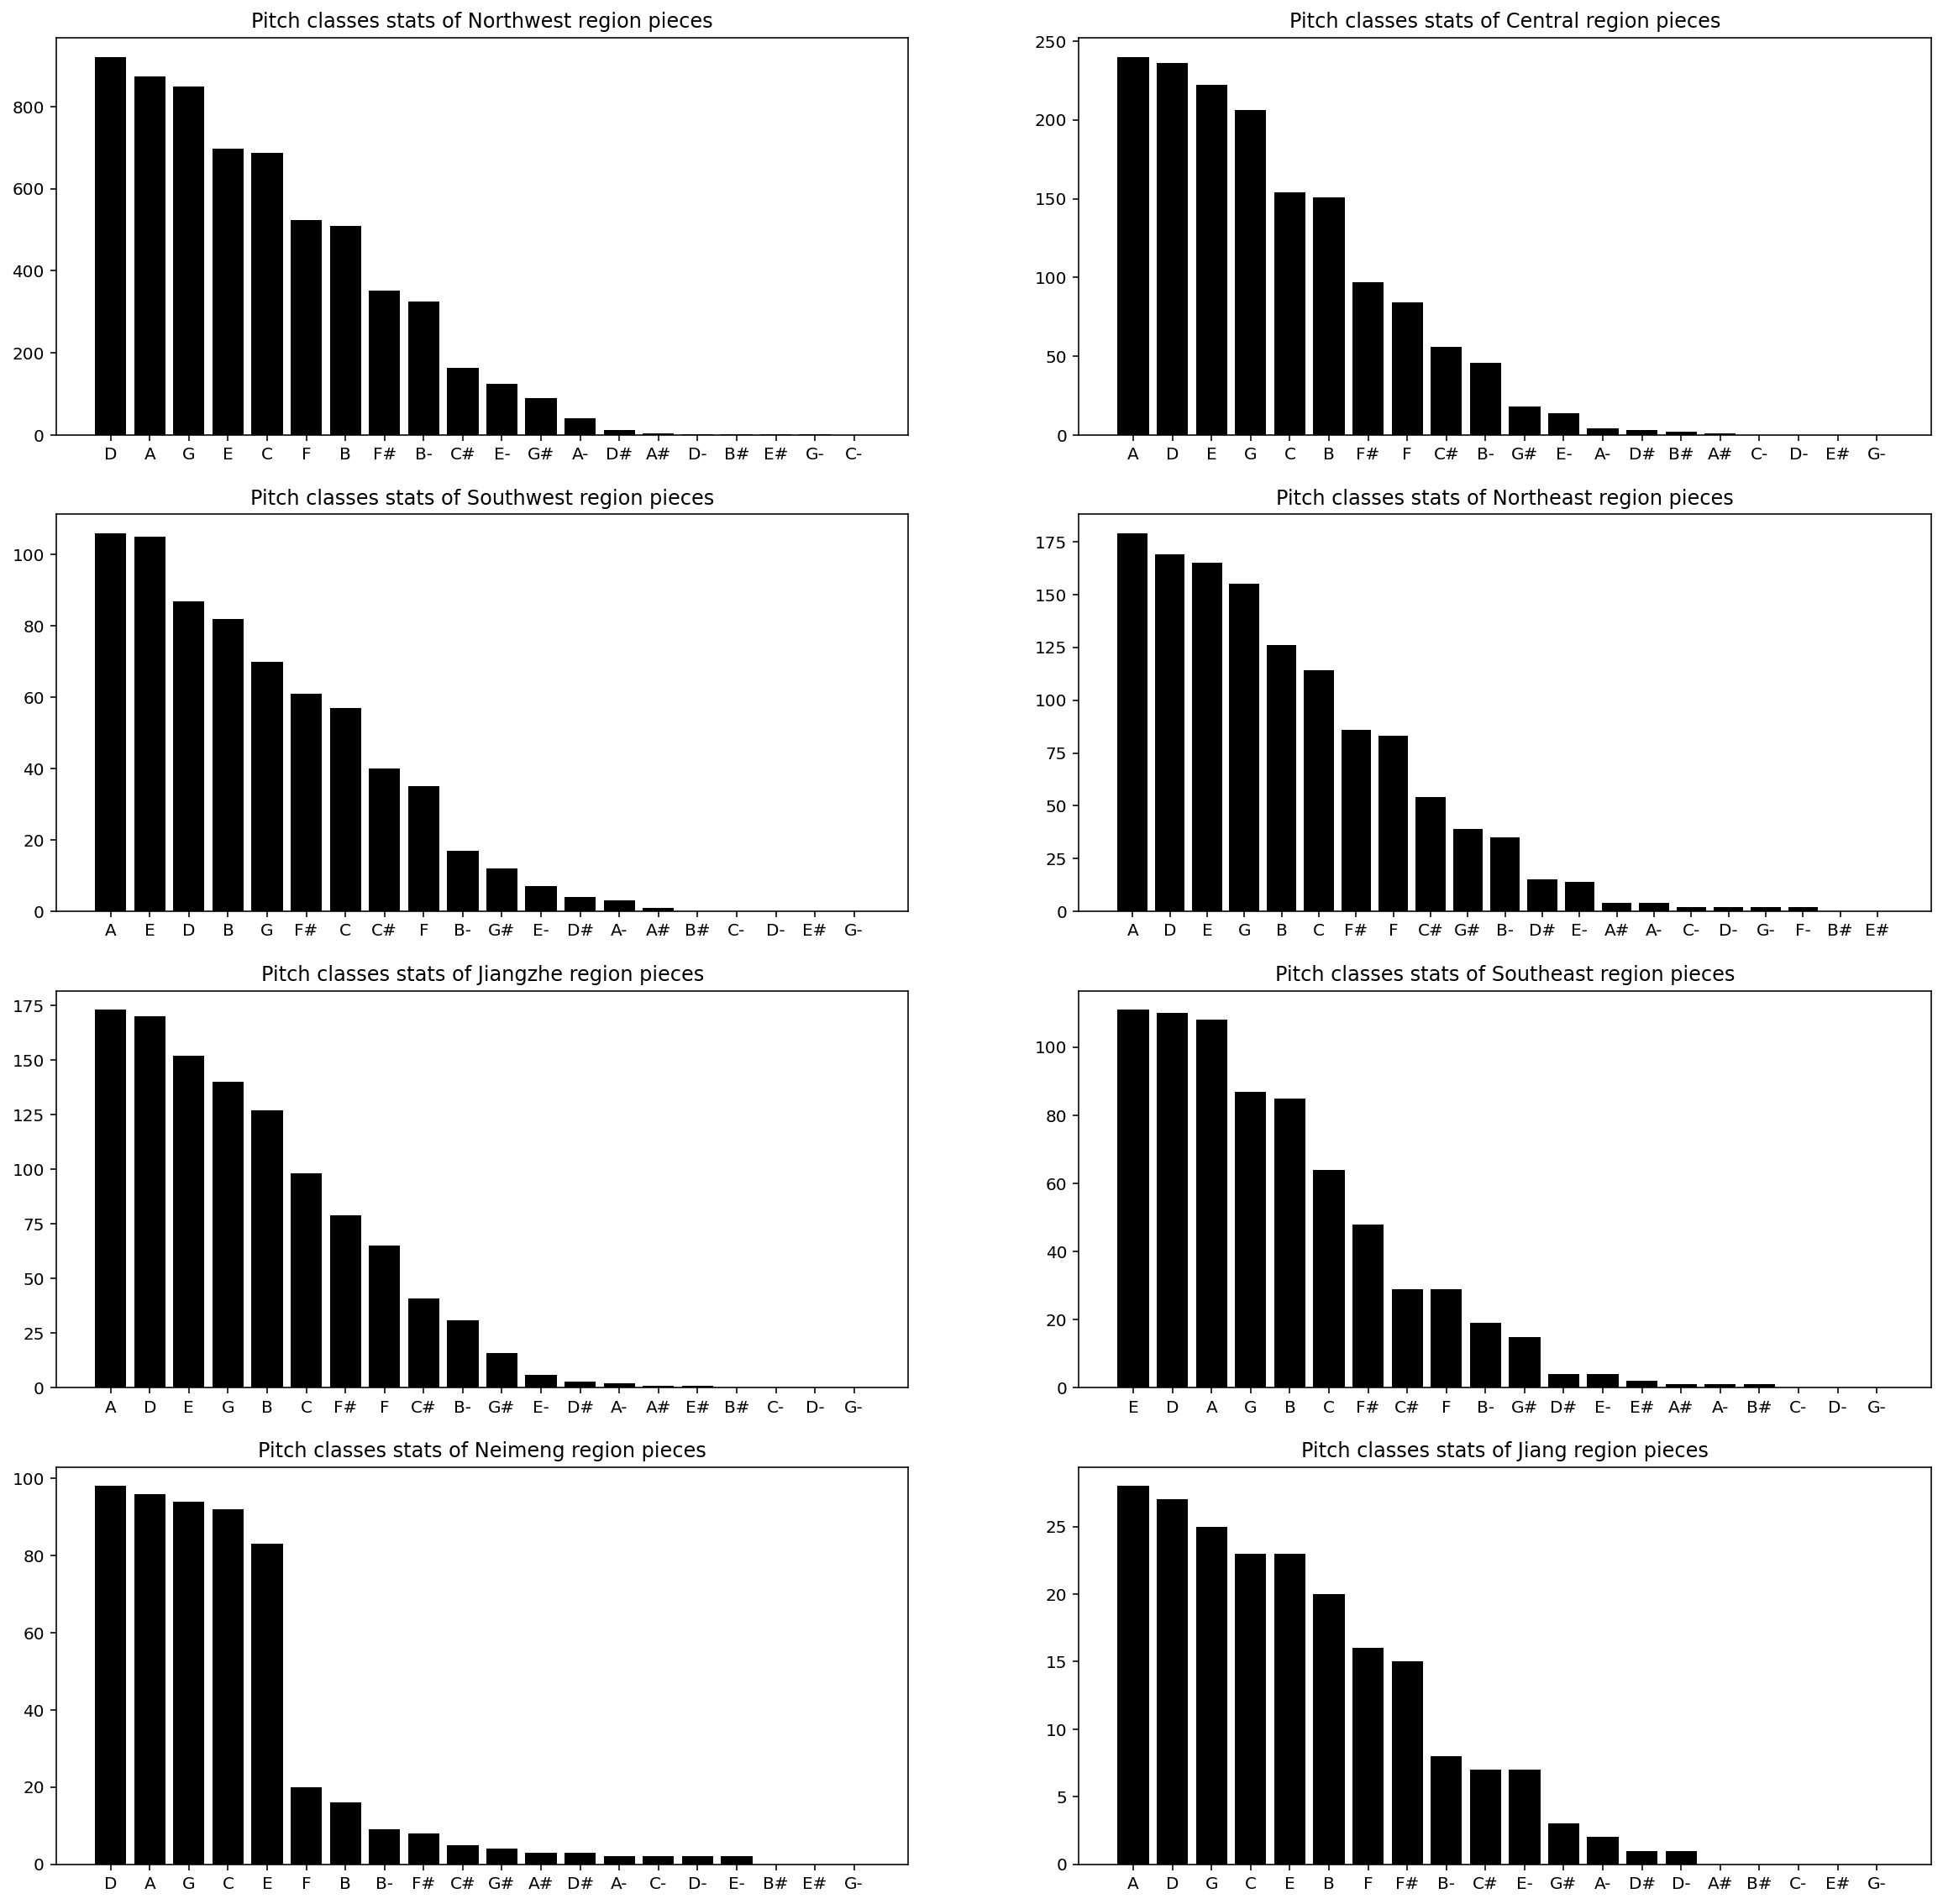

In [152]:
plt.rcParams["figure.figsize"] = (20,20)
region_scaledegree_counts = {}
fig, axarr = plt.subplots(4,2)

for gloc,ax in zip(region_scaledegree_stat, axarr.flat):
    
    counter = Counter(region_scaledegree_stat[gloc])
#     scaledegree_fractions = {i:counter[i] / len(region_scaledegree_stat[gloc]) for i in counter}
    scaledegree_fractions = {i:counter[i] for i in counter}
    scaledegree_fractions = {**scaledegree_defcount, **scaledegree_fractions}
    region_scaledegree_counts[gloc] = sorted(scaledegree_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_scaledegree_counts[gloc])
    ax.bar(x, y, color='black')
    ax.set_title("Pitch classes stats of {} region pieces".format(gloc))

A visual comparison of these plots again reveals a great similarity between all regions as `A`, `D` and `E` most often closely compete for the three most used pitch classes. However, we notice once again a significant difference in the Neimeng region, where there is a drop after the 5 most used pitch classes.

These results once again go against our hypothesis. However, the singular example of the Neimeng region must be remembered for the rest of the analysis.

A visual comparison of these plots again reveals a great similarity between all regions as `A`, `D` and `E` most often closely compete for the three most used pitch classes. However, we notice once again a significant difference in the Neimeng region, where there is a drop after the 5 most used pitch classes.

These results once again go against our hypothesis. However, the singular example of the Neimeng region must be remembered for the rest of the analysis.

### 2.2.3 Scale degrees statistics
In our research questions, we were particularly interested in the organization of the piece around the central pitch. For that reason, we transposed all pieces to C relatively to their tonic. Analyzing the pitches of these transposed scores reveals information about the use of scale degrees.

As a first analysis, we plot the distribution of use of scale degrees by simply counting them. Note that for simplicity, instead of labeling the plots with scale degrees, they are simply labeled with their pitch class relative to C. Therefore G is V, D is II, etc...

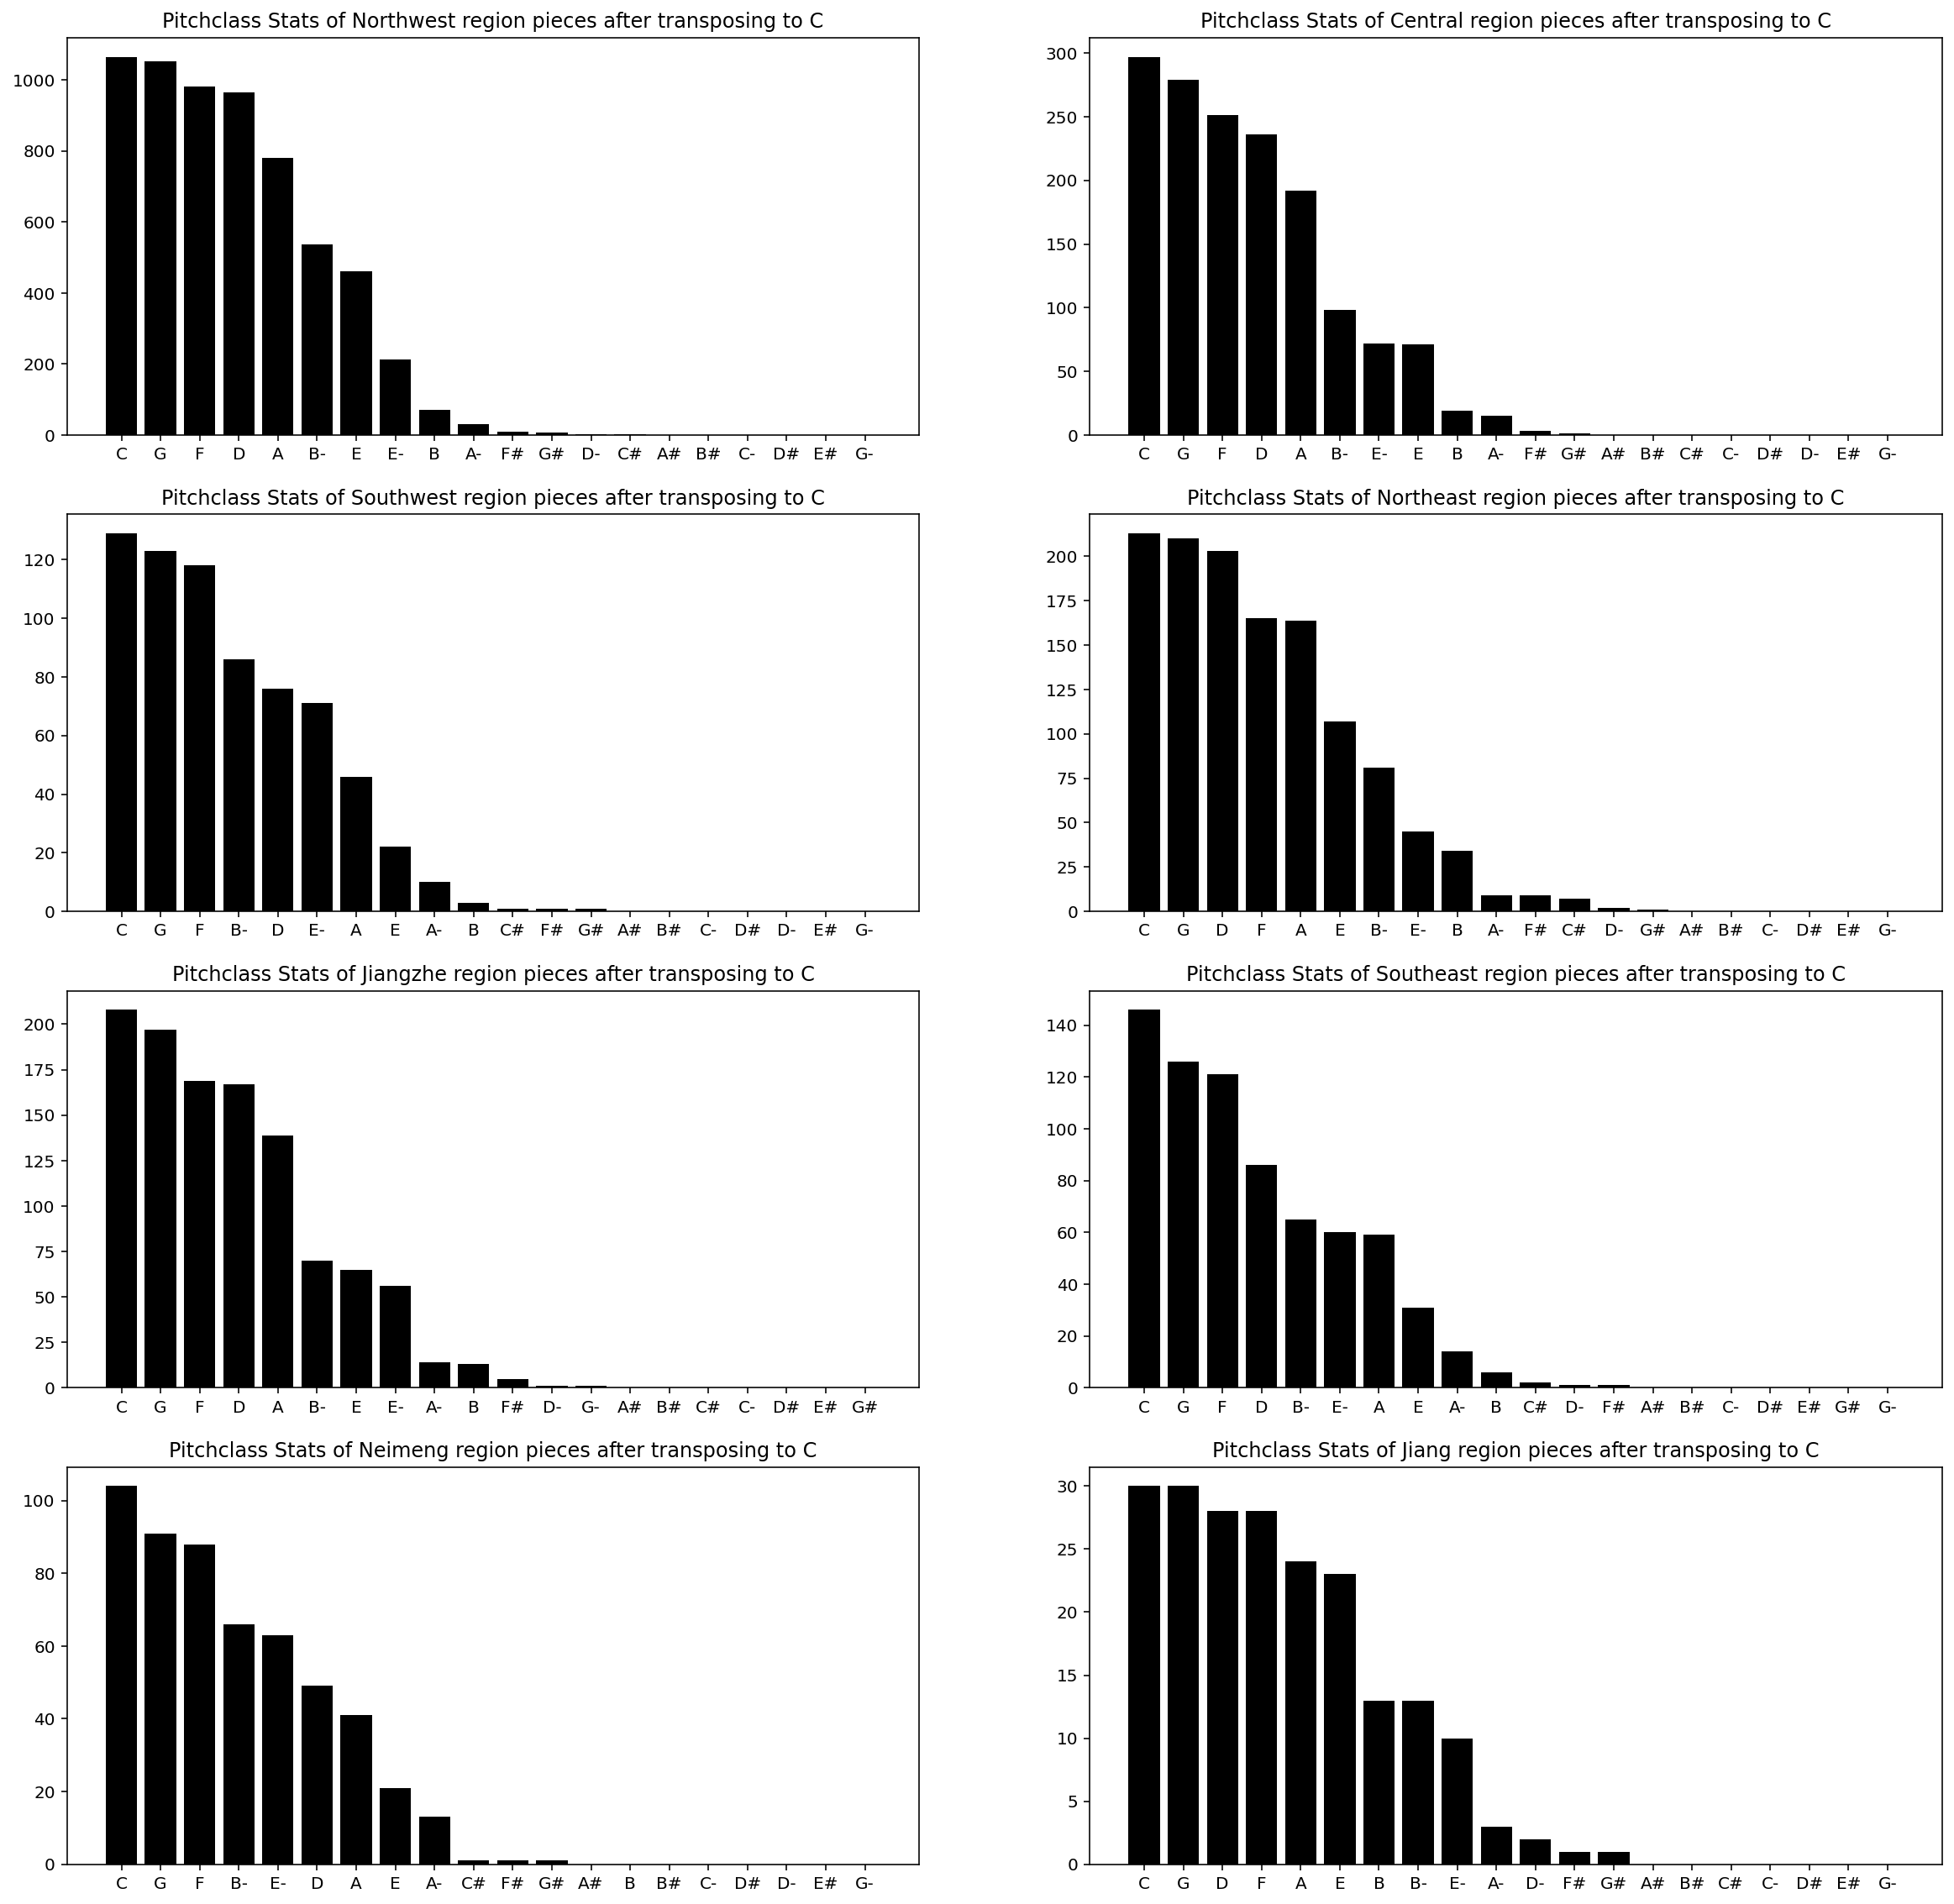

In [153]:
plt.rcParams["figure.figsize"] = (20, 20)
fig, axarr = plt.subplots(4,2)

region_pitchclass_transposed_counts = {}

for gloc, ax in zip(region_pitchclass_transposed_stat, axarr.flat):
    
    counter = Counter(region_pitchclass_transposed_stat[gloc])
#     pitchclass_transposed_fractions = {i:counter[i] / len(region_pitchclass_transposed_stat[gloc]) for i in counter}
    pitchclass_transposed_fractions = {i:counter[i] for i in counter}
    pitchclass_transposed_fractions = {**pitchclasses_defcount, **pitchclass_transposed_fractions}
    region_pitchclass_transposed_counts[gloc] = sorted(pitchclass_transposed_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_pitchclass_transposed_counts[gloc])
    ax.bar(x, y, color='black')
    ax.set_title("Pitchclass Stats of {} region pieces after transposing to C".format(gloc))
#     plt.show()

These plots reveal that the distributions of use of scale degrees across regions are vastly similar, thus once again refuting our initial hypothesis. However, it is interesting to note that like in Western music, the fifth and fourth are the most dominant scale degrees.

### 2.2.4 Pitch Classes Transitions

Another means to compare the organization of songs of different divisions is to look at the transitions between the pitches. Comparing these transitions will reveal whether the folks preferred certain pitch transitions to others and may show significant differences across regions.

For this purpose, we create a dictionary to store the count of transitions of the pitch classes in all pieces belonging to one division. The name of the division is the key of the mentioned dictionary and the value is a nested dictionary with keys as the starting pitch class and the values as dictionaries with key as the transitioned pitch class and value as the count of such occurrence.

In [154]:
pitchclass_transition = {geo_region: {} for geo_region in geo_divisions}

for gloc in tqdm(music_data):
    
    for score in music_data[gloc]["scores"]:
        region = CFS_full[CFS_full["title"] == score.metadata.title].geo_division.values[0]
        if region != "Null":
            for part in score.parts:
                for measure in part:
                    if type(measure) is not stream.Measure:
                        continue
                    prev = None
                    for note_ in measure:
                        if type(note_) is not note.Note:
                            continue
                        if prev != None:
                            if prev not in pitchclass_transition[region]:
                                pitchclass_transition[region][prev] = {}
                            if note_.name not in  pitchclass_transition[region][prev]:
                                pitchclass_transition[region][prev][note_.name] = 1
                            else:
                                pitchclass_transition[region][prev][note_.name] += 1
                        prev = note_.name
                
for geo_region in pitchclass_transition:
    pitchclass_transition[geo_region] = {**pitchclass_transitions_defcount, **pitchclass_transition[geo_region]}

100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


Now using the pitch class transitions in each division we create a network with pitch class as the nodes and creating an edge in case there is a transition between the nodes. The graph will be directed meaning there exists an edge only in the direction where the pitch transition occurs.

We create the `plot_network` function to plot this network. The size of the nodes is dependent on the node degree (Degree of a node in a network is the number of connections it has to other nodes) and the thickness of edges is proportional to the count of transitions between those nodes. We also plot the transitions as heatmaps to help in the interpretation. To create them, we first convert the transition counts from a dictionary to a `DataFrame` and use it to plot the heatmap.

In [155]:
plt.rcParams["figure.figsize"] = (20,8)
def plot_network(graph, ax):
    weighted_degree = dict(graph.degree(weight='weight'))
    edges = graph.edges()
    weights = [0.002 * graph[u][v]['weight'] for u,v in edges]
    nx.draw_circular(graph, with_labels=True, alpha = 0.6, width=weights,
                  node_size=[v * 0.1 for v in weighted_degree.values()], ax=ax)
    ax.axis("off")

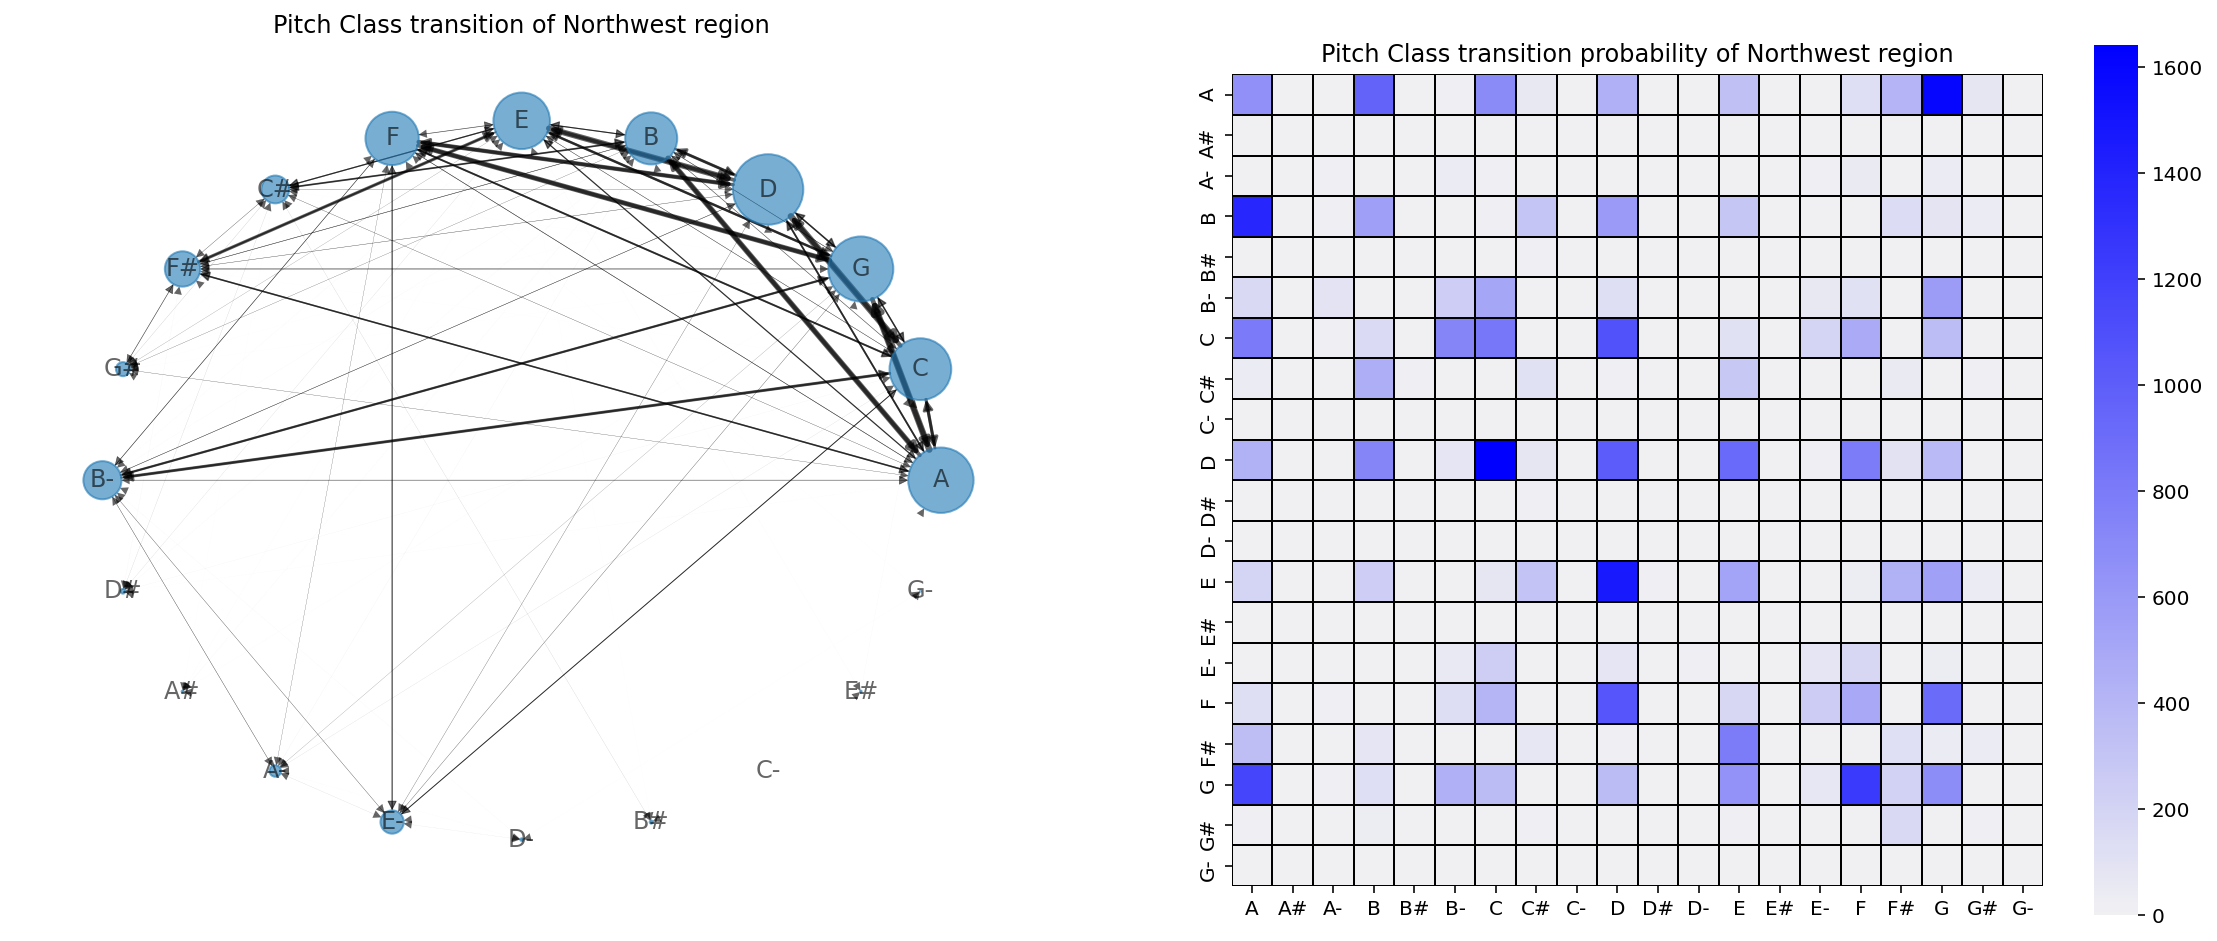

----------------------------------------------------------------------------------------------------------------------------------------------------------------


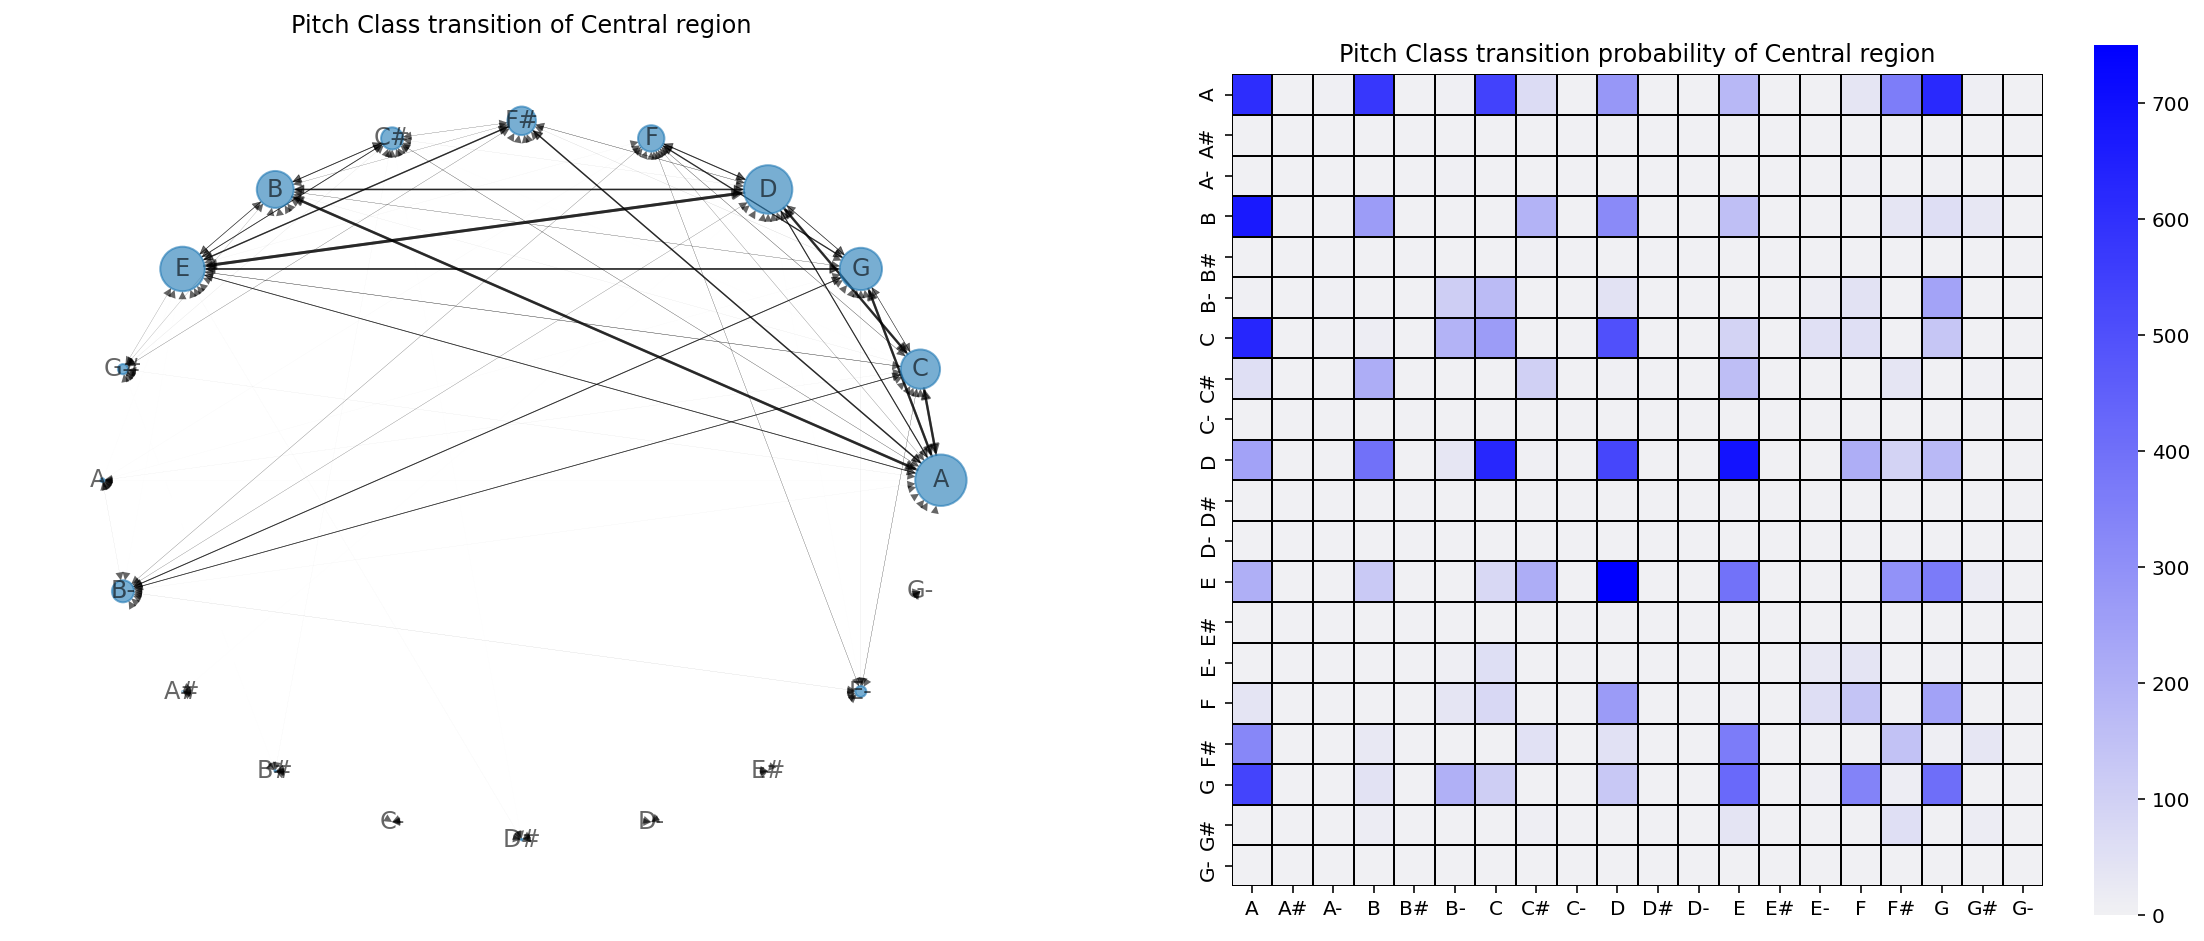

----------------------------------------------------------------------------------------------------------------------------------------------------------------


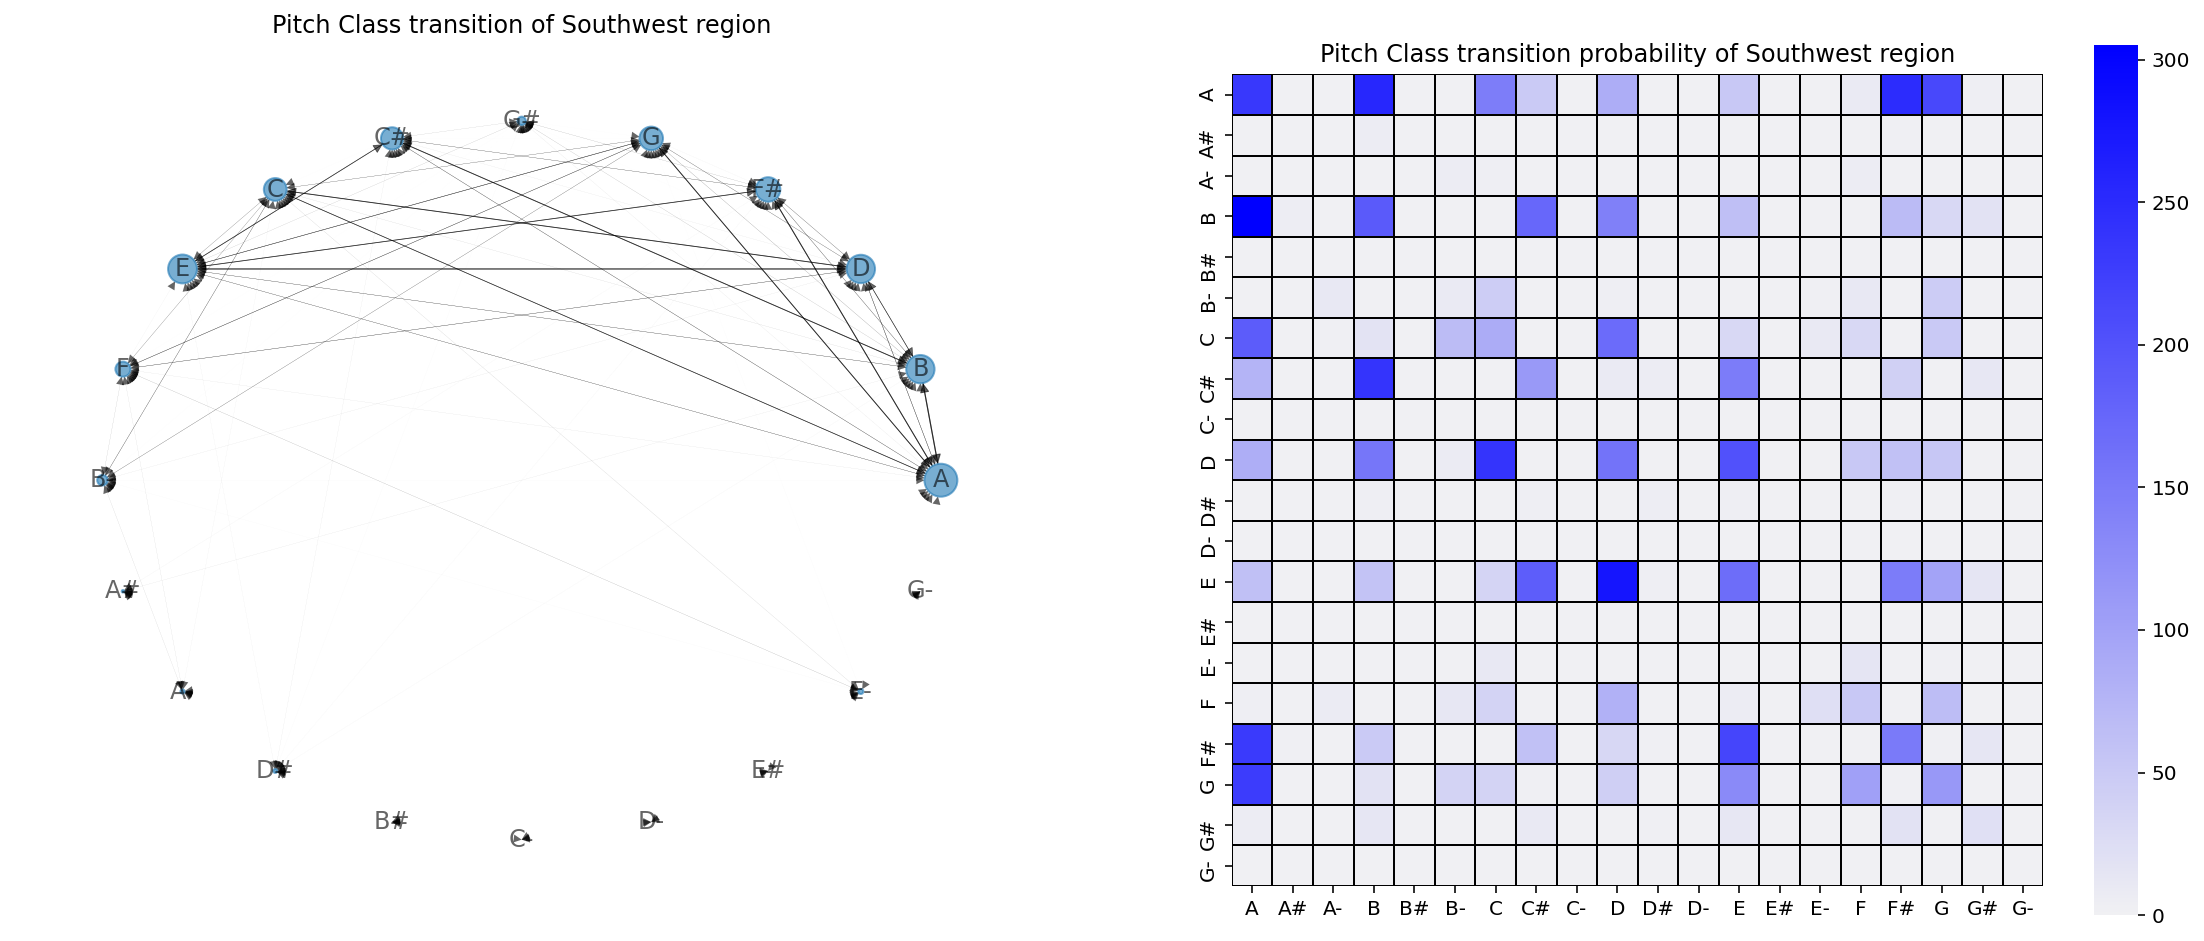

----------------------------------------------------------------------------------------------------------------------------------------------------------------


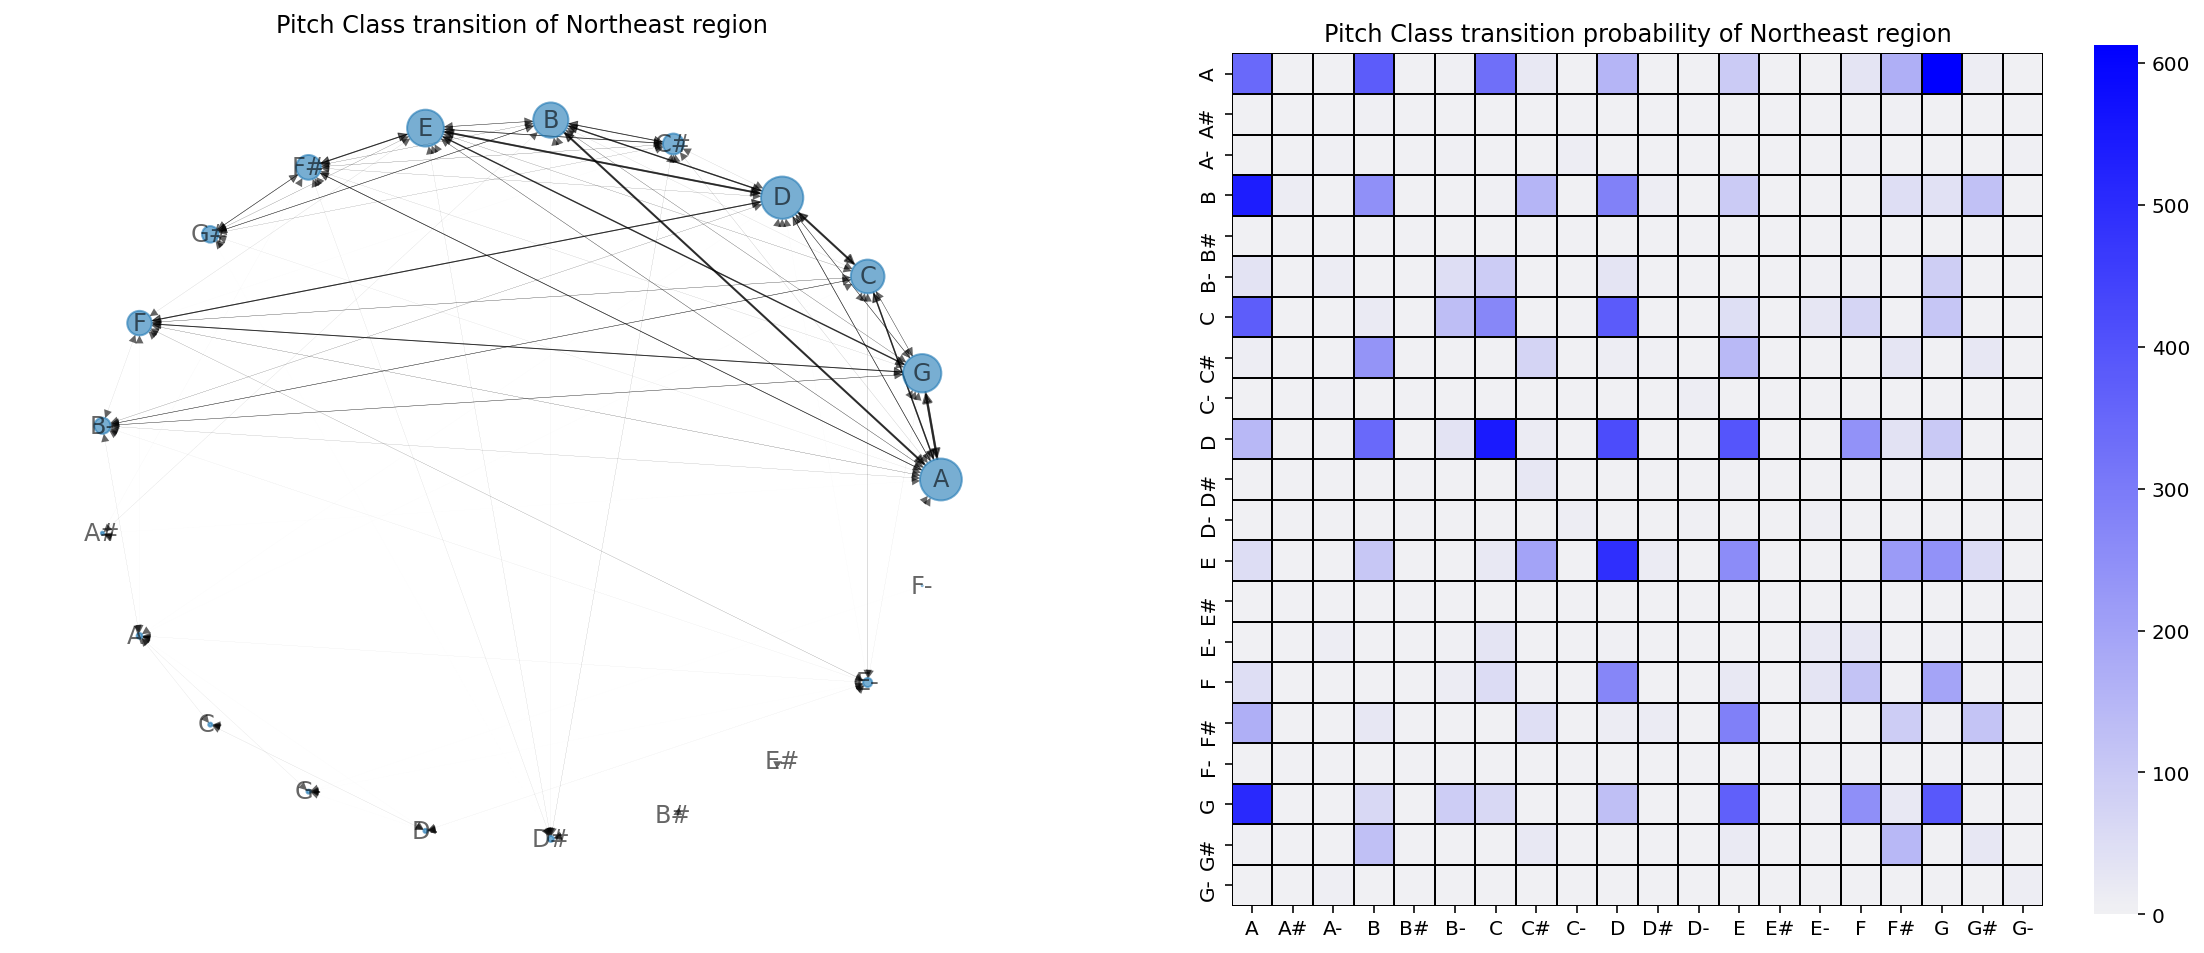

----------------------------------------------------------------------------------------------------------------------------------------------------------------


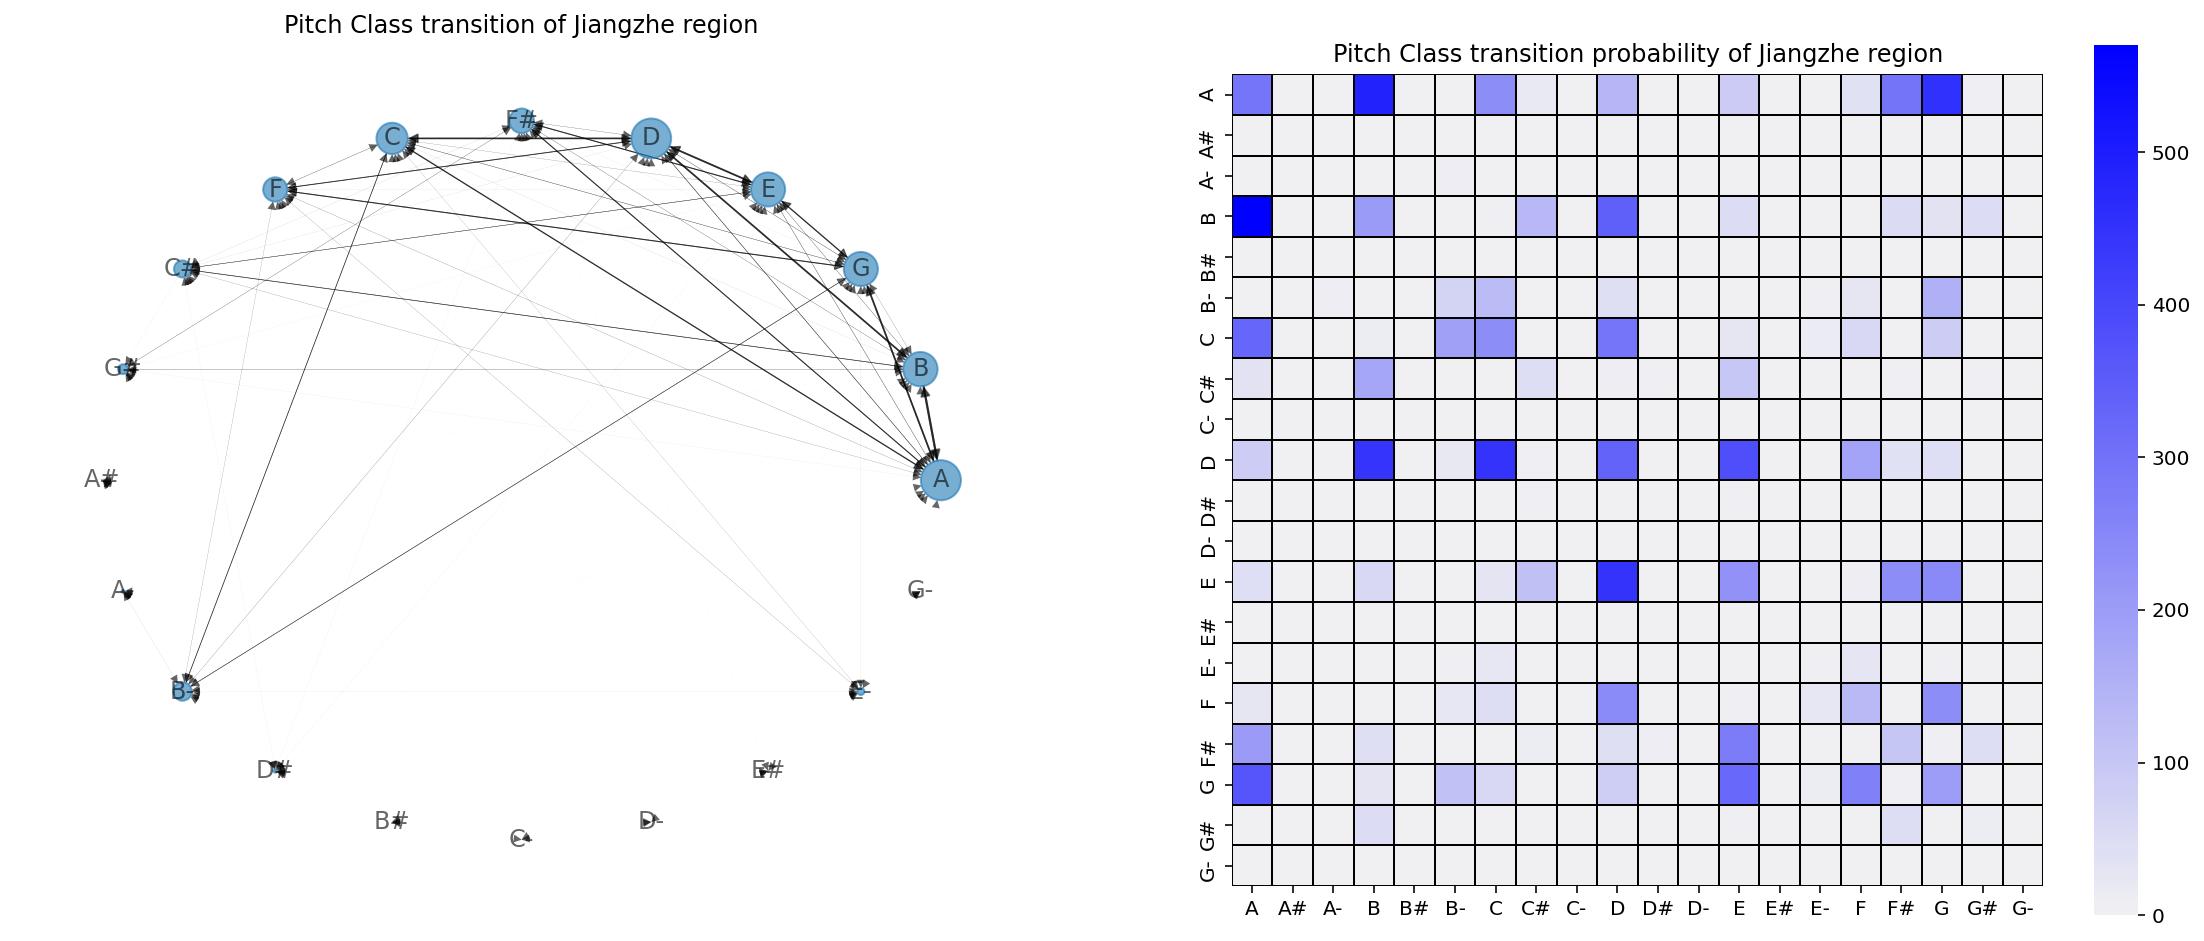

----------------------------------------------------------------------------------------------------------------------------------------------------------------


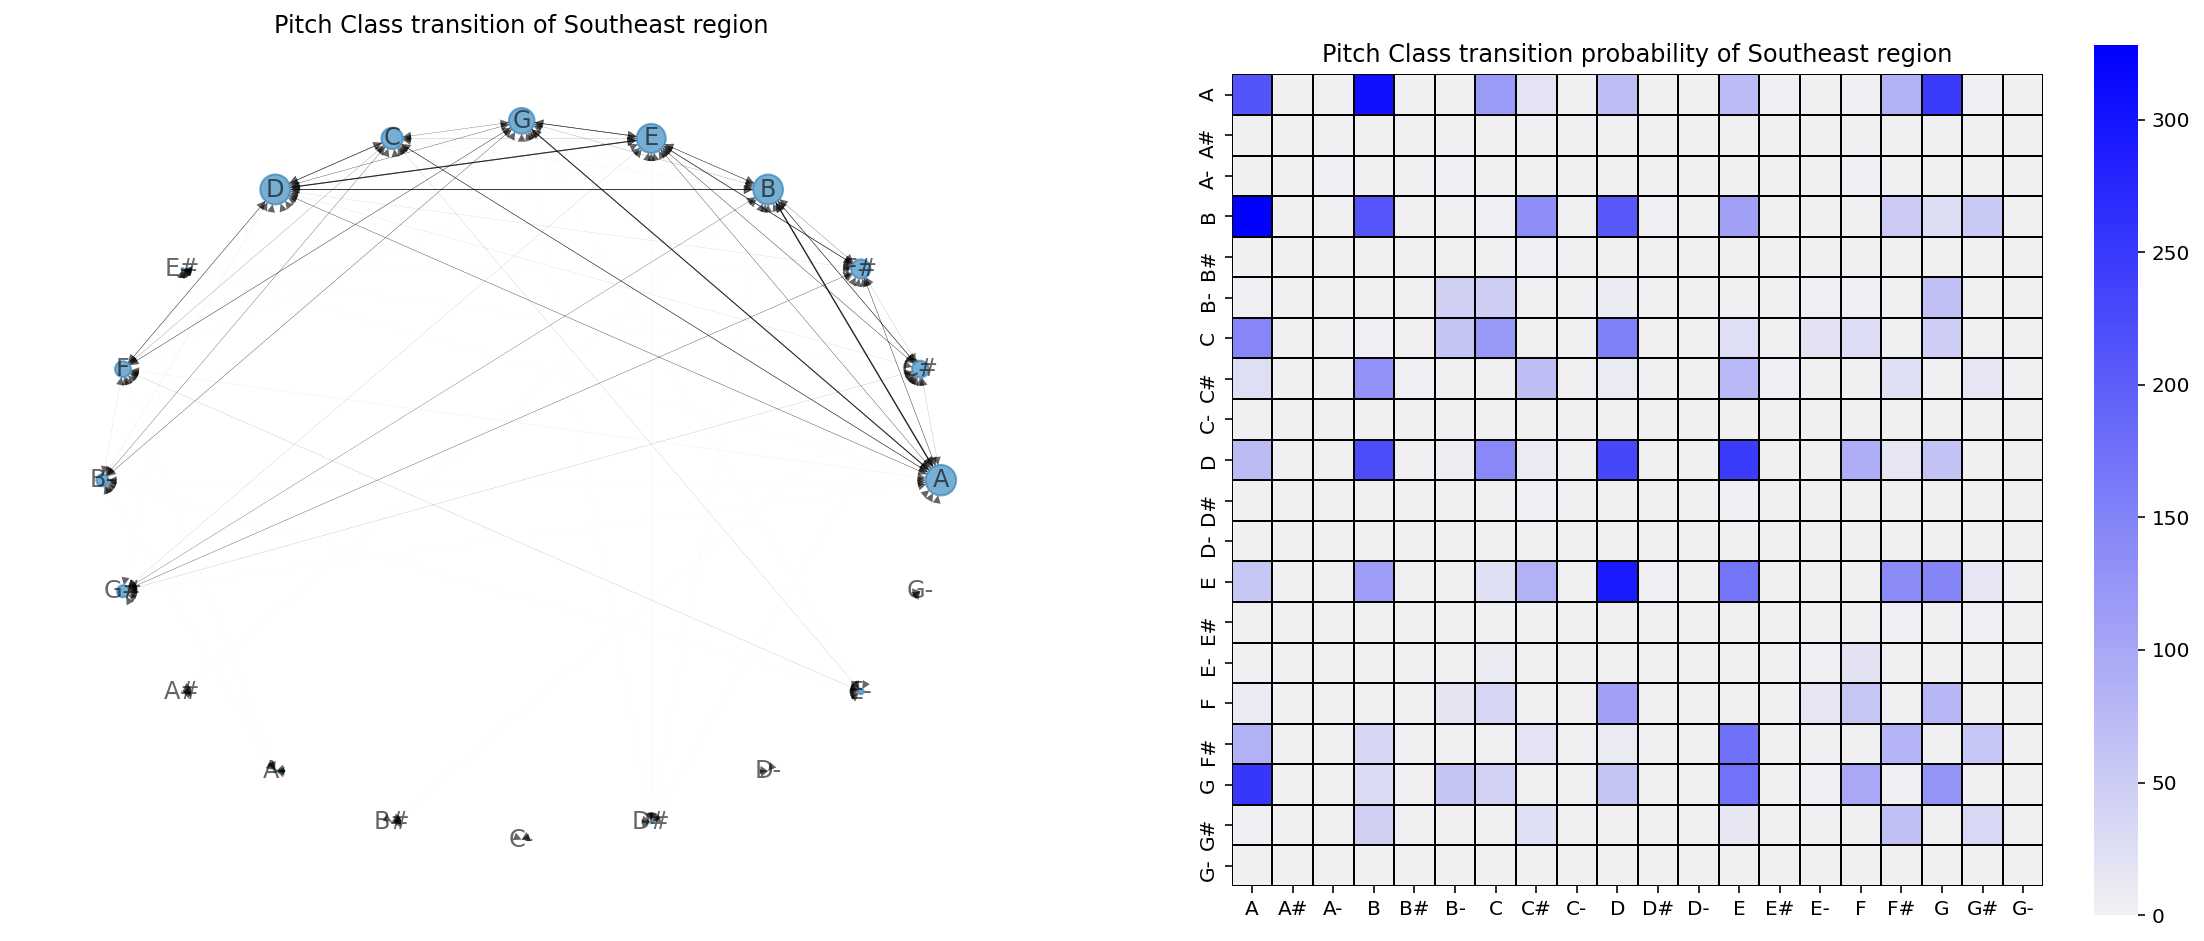

----------------------------------------------------------------------------------------------------------------------------------------------------------------


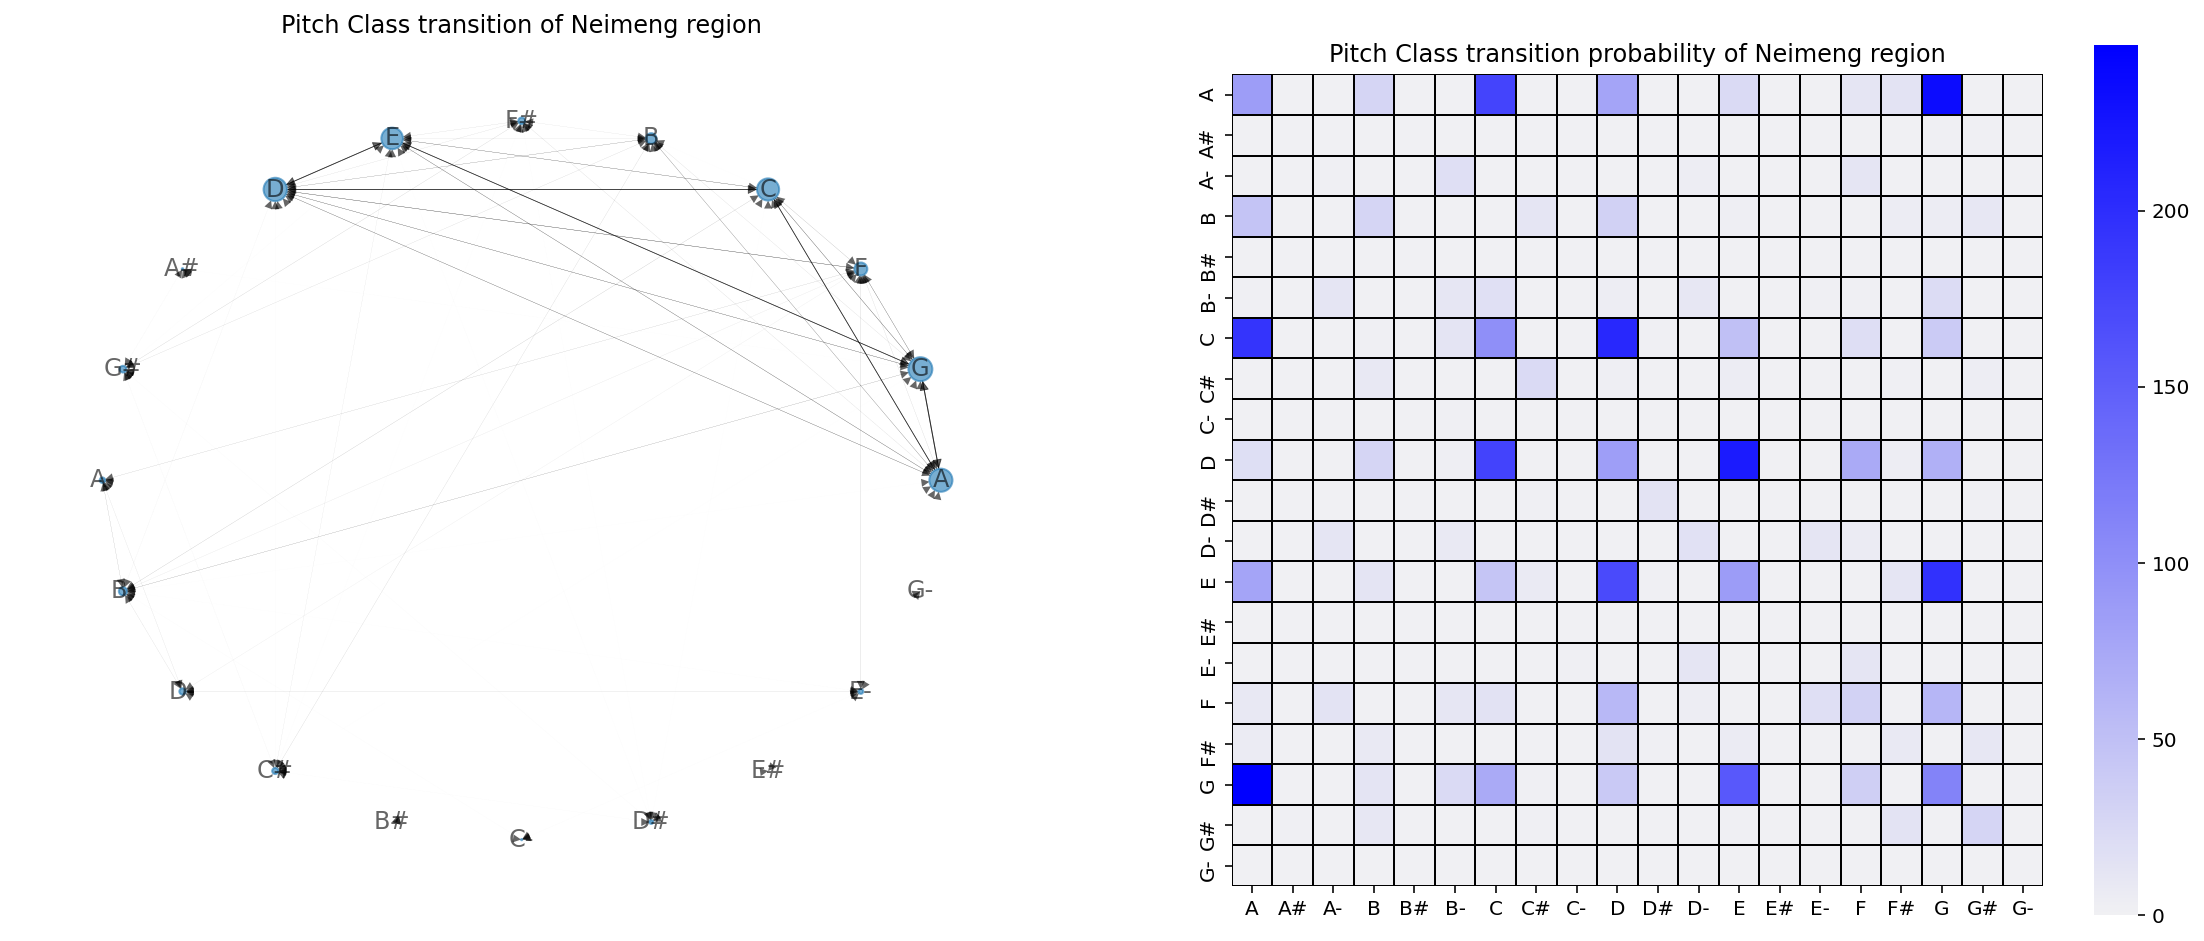

----------------------------------------------------------------------------------------------------------------------------------------------------------------


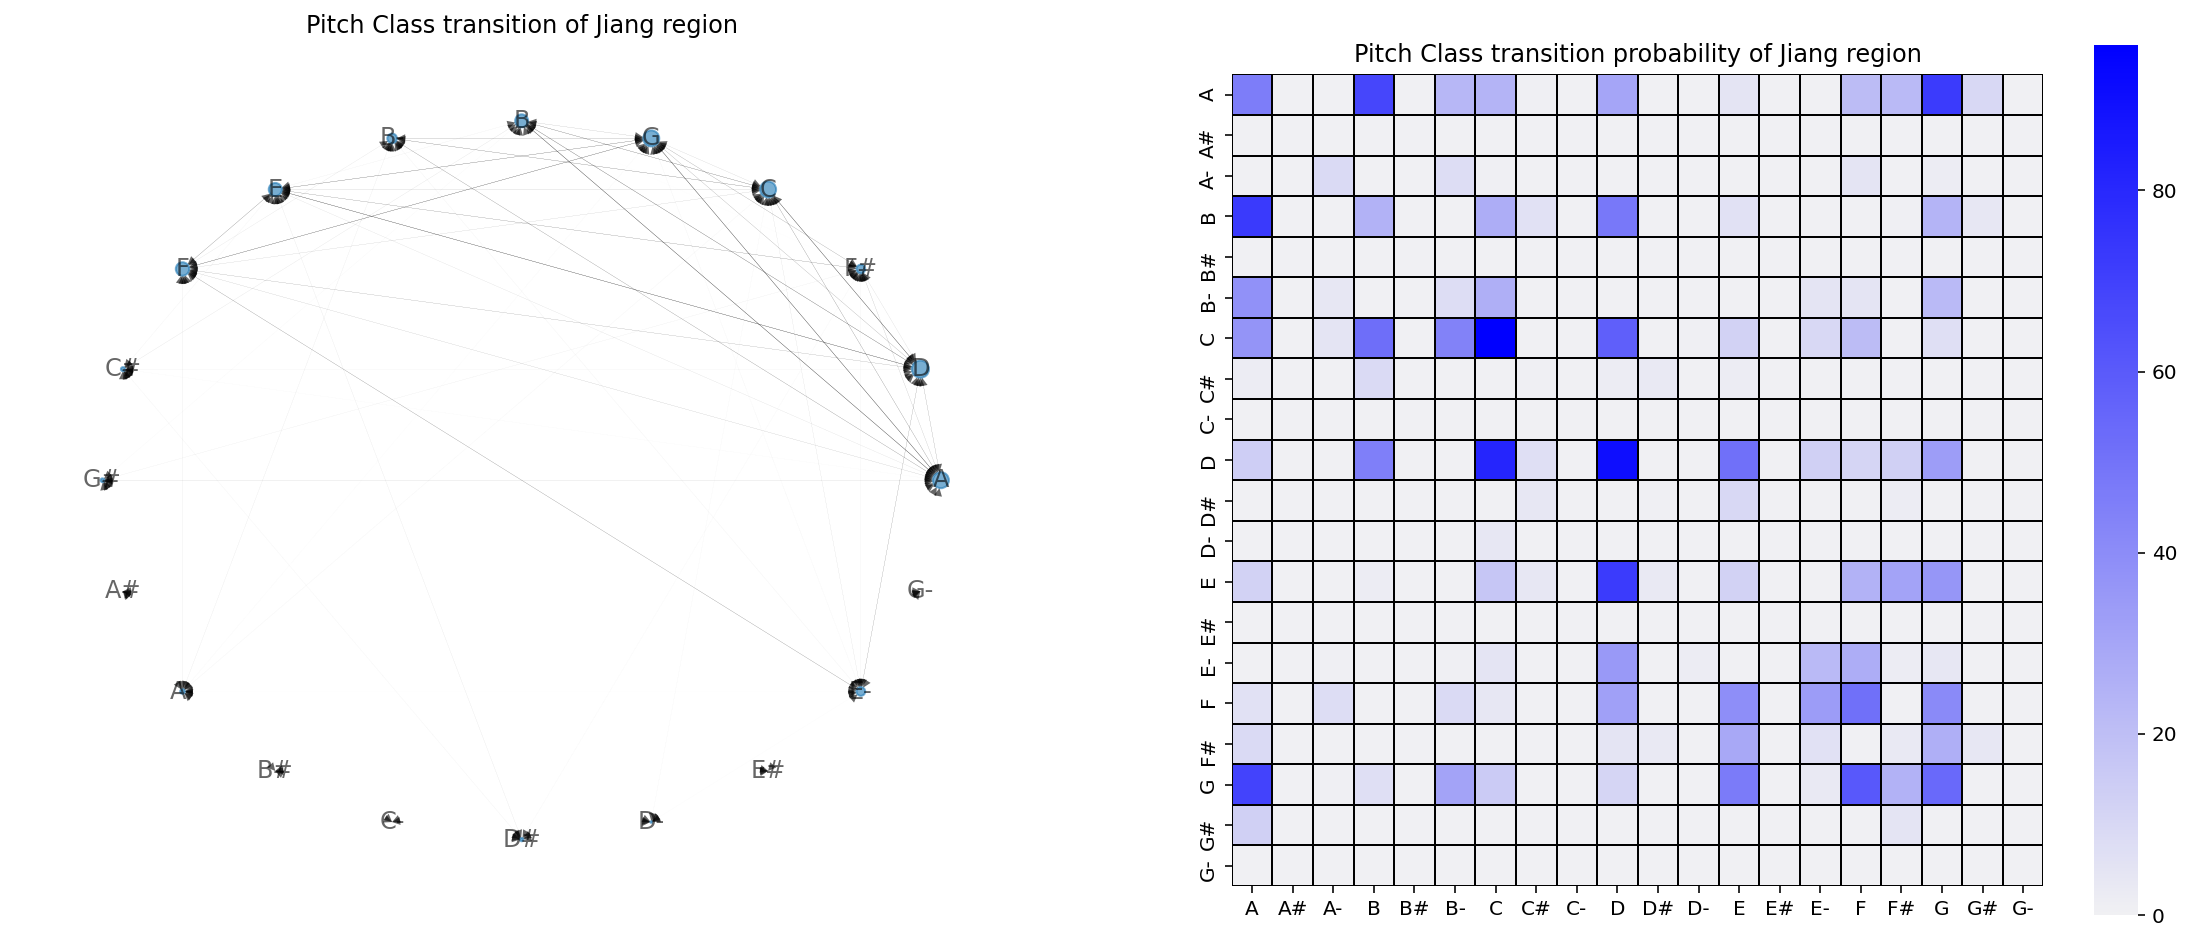

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [156]:
def sort_dict(item):
    # function to sort a nested dictionary based on key
    # credits: https://gist.github.com/gyli/f60f0374defc383aa098d44cfbd318eb
    return {k: sort_dict(v) if isinstance(v, dict) else v for k, v in sorted(item.items())}

colormap = sns.color_palette("light:b", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,2)
    gloc_graph = nx.DiGraph((k, v, {'weight': weight}) for k, vs in pitchclass_transition[gloc].items() for v, weight in vs.items())
    axes[0].set_title("Pitch Class transition of {} region".format(gloc))
    plot_network(gloc_graph, axes[0])
    
    sorted_probs = sort_dict(pitchclass_transition[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes[1] = ax1
    ax1.set_title("Pitch Class transition probability of {} region".format(gloc))
    plt.show()
    
    print("--"*80)

The graphs and heatmaps above reveal both similarities and differences in the pitches transitions across the different regions. For instance, we can observe that in all regions, Bs and Gs are most often followed by an A. However, it also appears that while some regions make frequent use of consecutive As (e.g. Central and Southwest), others barely use that transition (e.g. Northwest and Neimeng). From the map provided in section 2.1, we can see that these regions sharing similarities also share borders. It also provides us with evidence the interval of transition is visibly different for each region. 

This analysis of pitch transitions thus gives a first difference in the organization of CFS and provides support to our hypothesis.

## 3. Next Steps

As we have found minimum evidence showing there are differences between the organization of the music in a different region, next we plan to quantitatively define these differences. Additionally, the heatmaps indicate to us that the interval between the pitches could also be an indicator of the music belonging to a region. Thus, in the next step, we shall look at intervals of transitions between the pitches in pieces belonging to each division to extract preferred intervals of songs for each division.

## 4. Conclusion
At the end of this explorative data analysis, we observe that only a few of the comparing methods we used show significant differences across the eight regions of China we defined. Only the pitch transitions provide some insight on this matter. However, there is still more analysis that we haven't performed now and that may reveal regional characteristics. For example, we have only plotted the pitch transitions but have not done it for the scale degrees. Moreover, while we have currently only computed the distribution of scale degrees by counting them, we will also take into account its duration and beat strength in the next milestone.

Therefore, while our first results tend to refute our initial hypothesis, we hope that applying other methods and analyzing the results more precisely will bring more evidence of regional differences in the organization of CFS.

## 5. References


1. Essen Associative Code (EsAC) and folksong Database. http://www.esac-data.org/
2. Huron, D. (1994). UNIX tools for musical research: The humdrum toolkit reference manual. Stanford, CA: Center for Computer Assisted Research in Humanities.
3. Kern Scores, Folksongs from China. https://kern.humdrum.org/cgi-bin/browse?l=essen/asia/china 
4. Shi, Jiazi (2016), "East Meets West: A Musical Analysis of Chinese Sights and Sounds, by Yuankai Bao". LSU Doctoral Dissertations. 1762. https://digitalcommons.lsu.edu/gradschool_dissertations/1762
5. Cuthbert, M. S., & Ariza, C. (2010). music21: A toolkit for computer-aided musicology and symbolic music data. https://dspace.mit.edu/handle/1721.1/84963